# TELCO CHURN - EDA & ML & DL

#### Kullanılan Fonksiyonlar ve Kütüphaneler

In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import validation_curve, cross_validate, GridSearchCV,train_test_split
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.initializers import RandomNormal, RandomUniform, GlorotUniform, GlorotNormal, HeNormal
from joblib import dump, load
from tensorflow.keras.optimizers.schedules import ExponentialDecay # type: ignore
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner import RandomSearch, GridSearch
import pydotplus
import warnings
import random
from keras.metrics import AUC,Precision,Recall
warnings.filterwarnings("ignore")

random.seed(11)
np.random.seed(11)
tf.random.set_seed(11)

**GPU TEST FOR DL**

In [4]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Bulundu: {gpus}")
else:
    print("❌ GPU bulunamadı, CPU kullanılacak.")

print("GPU Var mı?:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA?:", tf.test.is_built_with_cuda())
print("TF versiyon:", tf.__version__)

✅ GPU Bulundu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Var mı?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA?: True
TF versiyon: 2.10.1


In [231]:
# with @MIUUL

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int64", "float64"]]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64","Int64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

X = list()
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(model, feature_names=col_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)

def check_errors(model,X_test,y_test,y_pred,if_cr=False, if_return = False):
    y_proba = model.predict_proba(X_test)[:,1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_proba)
    ll   = log_loss(y_test, y_proba)
    
    if if_cr:
        print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    if if_return:
        return acc,prec,rec,f1,auc,ll
    elif if_return == False:
        print(f""" Model {model}
        Accuracy : {acc:.4f}
        Precision: {prec:.4f}
        Recall   : {rec:.4f}
        F1       : {f1:.4f}
        ROC AUC  : {auc:.4f}
        Log Loss : {ll:.4f}
        """)

def cv_result_printer(cv_results):
    print(f"Accuracy:   {cv_results['test_accuracy'].mean():.4f}")
    print(f"Precision:  {cv_results['test_precision'].mean():.4f}")
    print(f"Recall:     {cv_results['test_recall'].mean():.4f}")
    print(f"F1:       {cv_results['test_f1'].mean():.4f}")
    print(f"ROC AUC:    {cv_results['test_roc_auc'].mean():.4f}")

def ml_final_table(models):
    mls = {}
    for model in models:
        mls.update({str(type(model)).split('.')[-1].replace("'>", ""):
         check_errors(model,X_test,y_test,model.predict(X_test),if_return=True)})
    
    mls = pd.DataFrame(mls,index=["Accuracy","Precision","Recall","F1","ROC AUC","Log Loss"])
    
    return mls.T

def get_best_epoch_details(history,loss="val_loss"):
    val_losses = history.history[loss]
    min_val_loss_index = val_losses.index(min(val_losses))
    best_epoch = min_val_loss_index +1

    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]
    
    epoch_details["best_epoch"] = best_epoch
    print(f"Best epoch details: {epoch_details}")

def prepare_datasets(X_train,X_val, y_train,y_val,batch_size=None):
    if batch_size is None:
        batch_size = len(X_train)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val))
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset

def try_initializers(train_ds,val_ds):
    initalizers = {
        "RandomNormal":RandomNormal(),
        "RandomUniform":RandomUniform(),
        "GlorotUniform":GlorotUniform(),
        "GlorotNormal":GlorotNormal(),
        "HeNormal":HeNormal()
    }

    for name, initalizer in initalizers.items():
        print()
        print(f"Training model with {name} initializaiton...")

        start_time = time.time()

        model = Sequential([
            Input(shape=(train_ds.element_spec[0].shape[1],)),
            Dense(50,activation="relu",kernel_initializer=initalizer, kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.5),
            Dense(1,activation="sigmoid",kernel_initializer=initalizer)
        ])
        model.compile(optimizer = "SGD", loss="binary_crossentropy",metrics=["accuracy"])
        early_stopping = EarlyStopping(monitor="val_loss",patience=200,verbose=0,restore_best_weights=True)
        history = model.fit(train_ds,epochs=1000,validation_data=val_ds,verbose=0,callbacks=early_stopping)
        get_best_epoch_details(history)

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time} seconds")

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(train_ds.element_spec[0].shape[1],)))

    for i in range(hp.Int("num_layers",1,5)):
        model.add(Dense(units=hp.Int("units_"+str(i), min_value=32,max_value=512,step=32),
                        activation=hp.Choice("activation_"+str(i),values=["relu","tanh","sigmoid"]),
                        kernel_regularizer=l2(hp.Float("l2_"+str(i),min_value=0.0001,max_value=0.01,sampling="log"))))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float("dropout_"+str(i),min_value=0.0,max_value=0.5,step=0.1)))
    model.add(Dense(1,activation="sigmoid"))

    initial_learning_rate = hp.Float("initial_learning_rate",min_value=1e-4,max_value=1e-2,sampling="log")
    lr_schedule = ExponentialDecay(
        initial_learning_rate = initial_learning_rate,
        decay_steps = 100,
        decay_rate = 0.96,
        staircase=True
    )

    optimizer_choice = hp.Choice("optimizer",values=["sgd","adam","rmsprop"])
    if optimizer_choice == "sgd":
        optimizer = SGD(
            learning_rate=lr_schedule,
            momentum=hp.Float("momentum",min_value=0.0,max_value=0.9,step=0.1)
        )
    elif optimizer_choice == "adam":
        optimizer = Adam(
            learning_rate=lr_schedule,
            beta_1=hp.Float("beta1",min_value=0.85,max_value=0.99,step=0.01),
            beta_2=hp.Float("beta2",min_value=0.999,max_value=0.9999,step=0.0001),
            epsilon=hp.Float("epsilon",min_value=1e-8,max_value=1e-7, step=1e-8)
        )
    elif optimizer_choice == "rmsprop":
        optimizer = RMSprop(
            learning_rate=lr_schedule,
            rho=hp.Float("rho",min_value=0.8,max_value=0.99,step=0.01),
            epsilon=hp.Float("epsilon",min_value=0.0,max_value=0.9,step=0.1),
            momentum=hp.Float("momentum",min_value=0.0, max_value=0.9,step=0.1)
        )

    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

def random_samples(scaler,data,num_samples=100):
    X = data.drop("Outcome",axis=1)
    X_scaled = scaler.fit_transform(X)
    new_dataset = tf.data.Dataset.from_tensor_slices((X_scaled)).batch(len(X))
    return new_dataset

def plot_training_history(history,train_loss="loss",train_metric="accuracy",val_loss="val_loss",val_metric="val_accuracy"):
    plt.figure(figsize=(10,5))
    plt.plot(history.history[train_loss],label="Training Loss")
    plt.plot(history.history[val_loss], label="Validation Loss")
    plt.title("Training and Valdiation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(history.history[train_metric],label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric],label=f"Validation: {val_metric}")
    plt.title(f"Training and Validation {train_metric} Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(f"{train_metric}")
    plt.legend()
    plt.show()

def add_results_from_history(history, model, X_val, y_val, model_name, result_tables=None, threshold=0.5):
    """
    - Best epoch: min(val_loss)
    - Tablo kolonları: Accuracy, Precision, Recall, F1, ROC AUC, Log Loss
    - F1 sklearn ile 0.5 eşikte hesaplanır.
    - ROC AUC ve Log Loss varsayılan olarak history'deki val_auc ve val_loss'tan alınır.
      (İstersen sklearn ile yeniden hesaplamak için yorum satırlarını açabilirsin.)
    """
    h = history.history
    if "val_loss" not in h:
        raise ValueError("history.history 'val_loss' içermiyor.")

    best_idx = int(np.argmin(h["val_loss"])) 
    best_epoch = best_idx + 1

    val_acc  = float(h.get("val_accuracy", [np.nan])[best_idx])
    val_prec = float(h.get("val_precision", [np.nan])[best_idx])
    val_rec  = float(h.get("val_recall", [np.nan])[best_idx])
    val_auc_hist  = float(h.get("val_auc", [np.nan])[best_idx])
    val_loss_hist = float(h["val_loss"][best_idx])

    proba = model.predict(X_val, verbose=0).ravel()
    pred  = (proba >= threshold).astype(int)

    f1 = float(f1_score(y_val, pred, zero_division=0))

    row = pd.Series({
        "Accuracy":  val_acc,
        "Precision": val_prec,
        "Recall":    val_rec,
        "F1":        f1,
        "ROC AUC":   val_auc_hist,
        "Log Loss":  val_loss_hist
    }, name=model_name)


    if result_tables is None or not isinstance(result_tables, pd.DataFrame):
        result_tables = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","ROC AUC","Log Loss"])

    result_tables = pd.concat([result_tables, row.to_frame().T], axis=0)
    return result_tables


## EXPLORATORY DAYA ANALYSİS (EDA)

### Veri Yükleme Ve Genel Bakış

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [7]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### check_df ile veriye genel bakış

In [8]:
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling          

#### Kolon isimlerini büyük harfe çevirme

In [9]:
df.columns = [col.upper() for col in df.columns]
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
CUSTOMERID           object
GENDER               object
SENIORCITIZEN         int64
PARTNER              object
DEPENDENTS           object
TENURE                int64
PHONESERVICE         object
MULTIPLELINES        object
INTERNETSERVICE      object
ONLINESECURITY       object
ONLINEBACKUP         object
DEVICEPROTECTION     object
TECHSUPPORT          object
STREAMINGTV          object
STREAMINGMOVIES      object
CONTRACT             object
PAPERLESSBILLING     object
PAYMENTMETHOD        object
MONTHLYCHARGES      float64
TOTALCHARGES         object
CHURN                object
dtype: object
##################### Head #####################
   CUSTOMERID  GENDER  SENIORCITIZEN PARTNER DEPENDENTS  TENURE PHONESERVICE     MULTIPLELINES INTERNETSERVICE ONLINESECURITY ONLINEBACKUP DEVICEPROTECTION TECHSUPPORT STREAMINGTV STREAMINGMOVIES        CONTRACT PAPERLESSBILLING          

#### Eksik değer analizi

In [10]:
df.isnull().sum()

CUSTOMERID          0
GENDER              0
SENIORCITIZEN       0
PARTNER             0
DEPENDENTS          0
TENURE              0
PHONESERVICE        0
MULTIPLELINES       0
INTERNETSERVICE     0
ONLINESECURITY      0
ONLINEBACKUP        0
DEVICEPROTECTION    0
TECHSUPPORT         0
STREAMINGTV         0
STREAMINGMOVIES     0
CONTRACT            0
PAPERLESSBILLING    0
PAYMENTMETHOD       0
MONTHLYCHARGES      0
TOTALCHARGES        0
CHURN               0
dtype: int64

#### TOTALCHARGES değişkeni sayısal olması gerekirken "object" gözüküyor.

In [11]:
df["TOTALCHARGES"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: TOTALCHARGES
Non-Null Count  Dtype 
--------------  ----- 
7043 non-null   object
dtypes: object(1)
memory usage: 55.1+ KB


#### TOTALCHARGES değişkeninde değerler string girilmiş ve nan değerler tırnak içinde bırakılmış

In [12]:
df[df.loc[:,"TOTALCHARGES"].str.contains(" ") == True]["TOTALCHARGES"].values

array([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
      dtype=object)

#### Tırnak değerleri np.nan ile değiştirildi ve veriye tekrar genel bakış

In [13]:
df[df["TOTALCHARGES"] == " "]
df.loc[(df["TOTALCHARGES"] == " "),"TOTALCHARGES"] = np.nan

In [14]:
df[df["TOTALCHARGES"] == " "].any().sum()

0

In [15]:
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
CUSTOMERID           object
GENDER               object
SENIORCITIZEN         int64
PARTNER              object
DEPENDENTS           object
TENURE                int64
PHONESERVICE         object
MULTIPLELINES        object
INTERNETSERVICE      object
ONLINESECURITY       object
ONLINEBACKUP         object
DEVICEPROTECTION     object
TECHSUPPORT          object
STREAMINGTV          object
STREAMINGMOVIES      object
CONTRACT             object
PAPERLESSBILLING     object
PAYMENTMETHOD        object
MONTHLYCHARGES      float64
TOTALCHARGES         object
CHURN                object
dtype: object
##################### Head #####################
   CUSTOMERID  GENDER  SENIORCITIZEN PARTNER DEPENDENTS  TENURE PHONESERVICE     MULTIPLELINES INTERNETSERVICE ONLINESECURITY ONLINEBACKUP DEVICEPROTECTION TECHSUPPORT STREAMINGTV STREAMINGMOVIES        CONTRACT PAPERLESSBILLING          

In [16]:
df.isnull().sum()

CUSTOMERID           0
GENDER               0
SENIORCITIZEN        0
PARTNER              0
DEPENDENTS           0
TENURE               0
PHONESERVICE         0
MULTIPLELINES        0
INTERNETSERVICE      0
ONLINESECURITY       0
ONLINEBACKUP         0
DEVICEPROTECTION     0
TECHSUPPORT          0
STREAMINGTV          0
STREAMINGMOVIES      0
CONTRACT             0
PAPERLESSBILLING     0
PAYMENTMETHOD        0
MONTHLYCHARGES       0
TOTALCHARGES        11
CHURN                0
dtype: int64

#### TOTALCHARGES hala object türünde. float64 çevirildi

In [17]:
df["TOTALCHARGES"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: TOTALCHARGES
Non-Null Count  Dtype 
--------------  ----- 
7032 non-null   object
dtypes: object(1)
memory usage: 55.1+ KB


In [18]:
df["TOTALCHARGES"] = df["TOTALCHARGES"].astype(float)

In [19]:
df["TOTALCHARGES"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: TOTALCHARGES
Non-Null Count  Dtype  
--------------  -----  
7032 non-null   float64
dtypes: float64(1)
memory usage: 55.1 KB


#### TOTALCHARGES değişkeninin boş değerlerinin diğer değerler ile ilişkisi incelendi. TENURE değişkeninin 0 olduğu tüm değerlerde TOTALCHARGES de nan olmuş. Yani o da 0 olmalı.

In [20]:
df.loc[(df["TOTALCHARGES"].isna()),["CONTRACT","MONTHLYCHARGES","TOTALCHARGES","TENURE"]]

,CONTRACT,MONTHLYCHARGES,TOTALCHARGES,TENURE
488,Two year,52.55,NaN,0
753,Two year,20.25,NaN,0
936,Two year,80.85,NaN,0
1082,Two year,25.75,NaN,0
1340,Two year,56.05,NaN,0
3331,Two year,19.85,NaN,0
3826,Two year,25.35,NaN,0
4380,Two year,20.00,NaN,0
5218,One year,19.70,NaN,0
6670,Two year,73.35,NaN,0


In [21]:
df["TOTALCHARGES"].fillna(0, inplace=True)

In [22]:
check_df(df)

##################### Shape #####################
(7043, 21)
##################### Types #####################
CUSTOMERID           object
GENDER               object
SENIORCITIZEN         int64
PARTNER              object
DEPENDENTS           object
TENURE                int64
PHONESERVICE         object
MULTIPLELINES        object
INTERNETSERVICE      object
ONLINESECURITY       object
ONLINEBACKUP         object
DEVICEPROTECTION     object
TECHSUPPORT          object
STREAMINGTV          object
STREAMINGMOVIES      object
CONTRACT             object
PAPERLESSBILLING     object
PAYMENTMETHOD        object
MONTHLYCHARGES      float64
TOTALCHARGES        float64
CHURN                object
dtype: object
##################### Head #####################
   CUSTOMERID  GENDER  SENIORCITIZEN PARTNER DEPENDENTS  TENURE PHONESERVICE     MULTIPLELINES INTERNETSERVICE ONLINESECURITY ONLINEBACKUP DEVICEPROTECTION TECHSUPPORT STREAMINGTV STREAMINGMOVIES        CONTRACT PAPERLESSBILLING          

#### Gerekli bilgi taşımayan "CUSTOMERID" sütunu düşürüldü.

In [23]:
dropped_columns = ["CUSTOMERID"]
df.drop(dropped_columns,inplace=True,axis=1)

In [24]:
check_df(df)

##################### Shape #####################
(7043, 20)
##################### Types #####################
GENDER               object
SENIORCITIZEN         int64
PARTNER              object
DEPENDENTS           object
TENURE                int64
PHONESERVICE         object
MULTIPLELINES        object
INTERNETSERVICE      object
ONLINESECURITY       object
ONLINEBACKUP         object
DEVICEPROTECTION     object
TECHSUPPORT          object
STREAMINGTV          object
STREAMINGMOVIES      object
CONTRACT             object
PAPERLESSBILLING     object
PAYMENTMETHOD        object
MONTHLYCHARGES      float64
TOTALCHARGES        float64
CHURN                object
dtype: object
##################### Head #####################
   GENDER  SENIORCITIZEN PARTNER DEPENDENTS  TENURE PHONESERVICE     MULTIPLELINES INTERNETSERVICE ONLINESECURITY ONLINEBACKUP DEVICEPROTECTION TECHSUPPORT STREAMINGTV STREAMINGMOVIES        CONTRACT PAPERLESSBILLING              PAYMENTMETHOD  MONTHLYCHARGES  TOTAL

#### Değişkenler türlerine göre ayrıldı.

In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [26]:
cat_cols

['GENDER',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'CHURN',
 'SENIORCITIZEN']

In [27]:
num_cols

['TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES']

In [28]:
cat_but_car

[]

In [29]:
df[cat_cols]

,GENDER,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,CHURN,SENIORCITIZEN
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,0
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,0
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,0
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,0
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No,0
7039,Female,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No,0
7040,Female,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,0
7041,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,1


In [30]:
df[num_cols]

,TENURE,MONTHLYCHARGES,TOTALCHARGES
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65
...,...,...,...
7038,24,84.80,1990.50
7039,72,103.20,7362.90
7040,11,29.60,346.45
7041,4,74.40,306.60


#### Kategorik ve nümerik olarak ayrılan değişkenlerin istatiksel betimlemeleri yapıldı.

        GENDER     Ratio
GENDER                  
Male      3555  50.47565
Female    3488  49.52435
##########################################


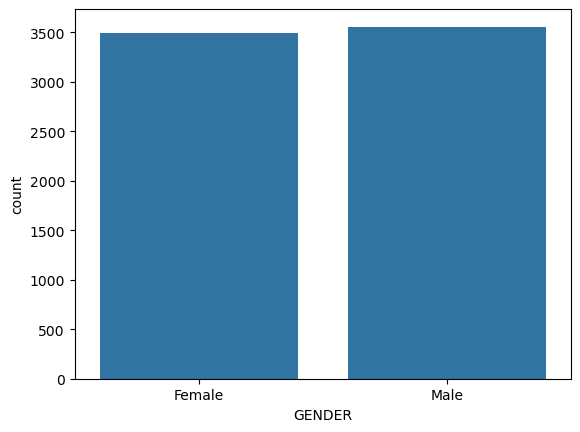

         PARTNER     Ratio
PARTNER                   
No          3641  51.69672
Yes         3402  48.30328
##########################################


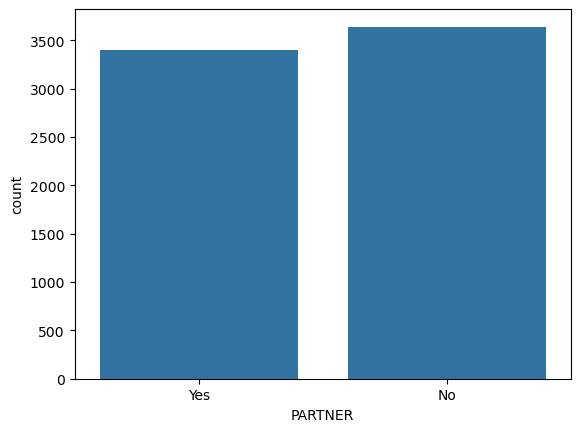

            DEPENDENTS      Ratio
DEPENDENTS                       
No                4933  70.041176
Yes               2110  29.958824
##########################################


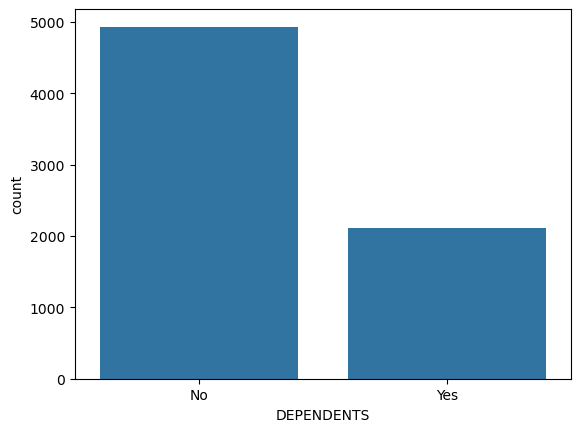

              PHONESERVICE      Ratio
PHONESERVICE                         
Yes                   6361  90.316626
No                     682   9.683374
##########################################


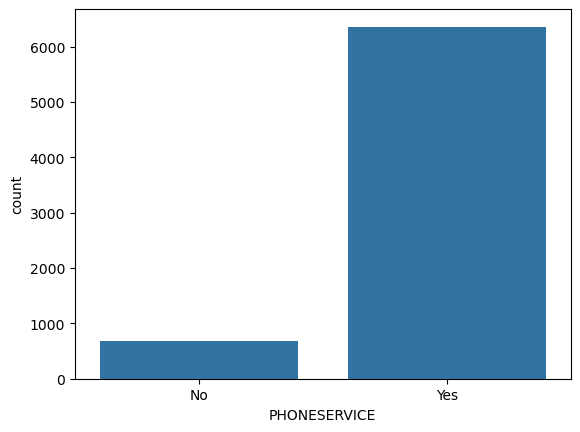

                  MULTIPLELINES      Ratio
MULTIPLELINES                             
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
##########################################


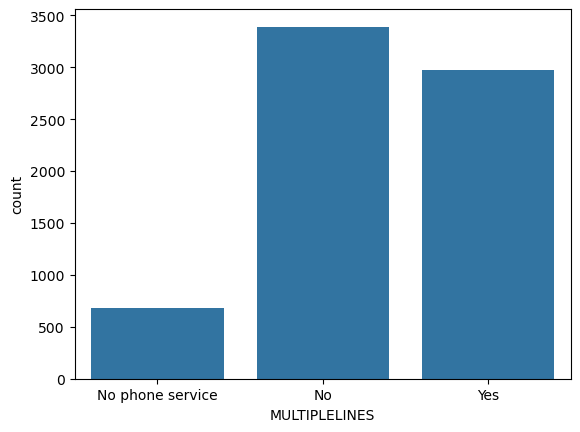

                 INTERNETSERVICE      Ratio
INTERNETSERVICE                            
Fiber optic                 3096  43.958540
DSL                         2421  34.374556
No                          1526  21.666903
##########################################


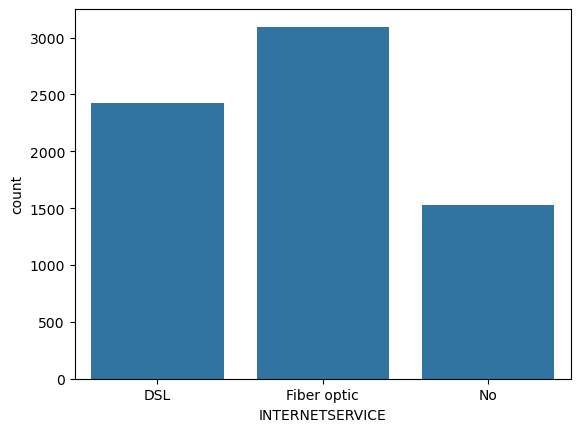

                     ONLINESECURITY      Ratio
ONLINESECURITY                                
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903
##########################################


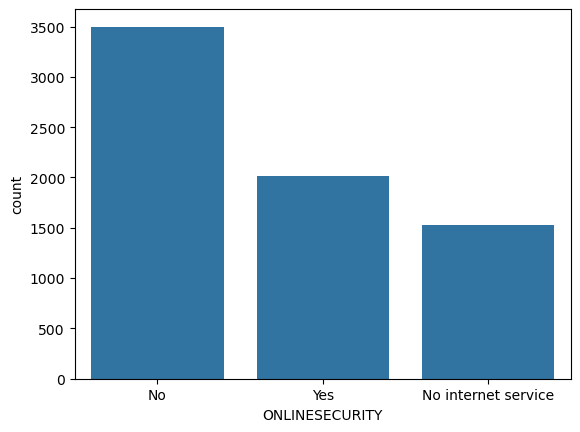

                     ONLINEBACKUP      Ratio
ONLINEBACKUP                                
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526  21.666903
##########################################


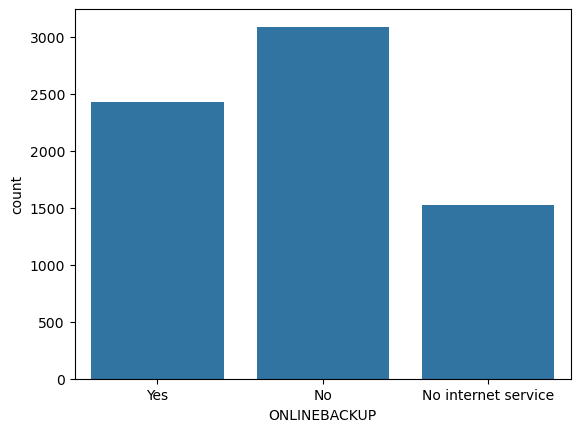

                     DEVICEPROTECTION      Ratio
DEVICEPROTECTION                                
No                               3095  43.944342
Yes                              2422  34.388755
No internet service              1526  21.666903
##########################################


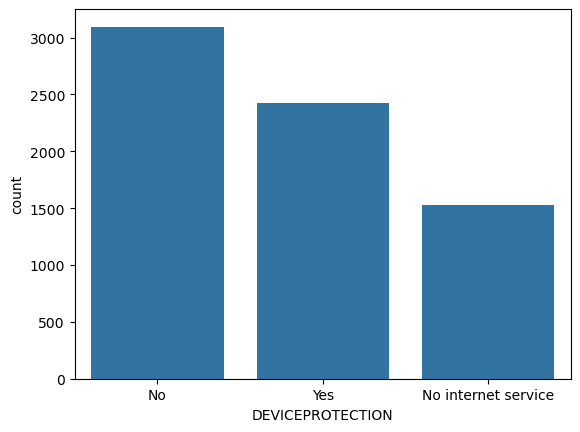

                     TECHSUPPORT      Ratio
TECHSUPPORT                                
No                          3473  49.311373
Yes                         2044  29.021724
No internet service         1526  21.666903
##########################################


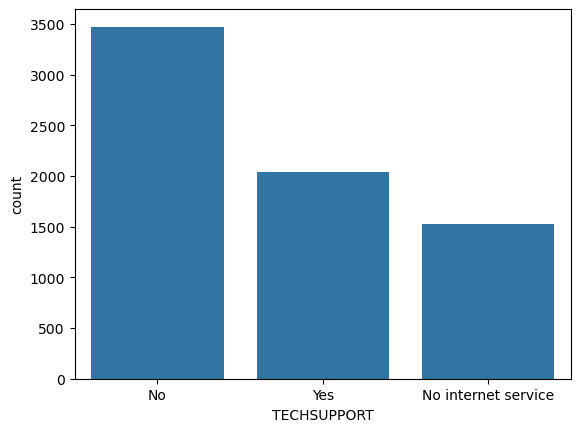

                     STREAMINGTV      Ratio
STREAMINGTV                                
No                          2810  39.897771
Yes                         2707  38.435326
No internet service         1526  21.666903
##########################################


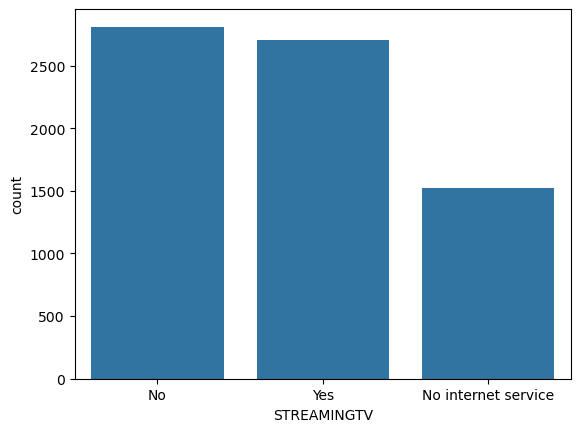

                     STREAMINGMOVIES      Ratio
STREAMINGMOVIES                                
No                              2785  39.542808
Yes                             2732  38.790288
No internet service             1526  21.666903
##########################################


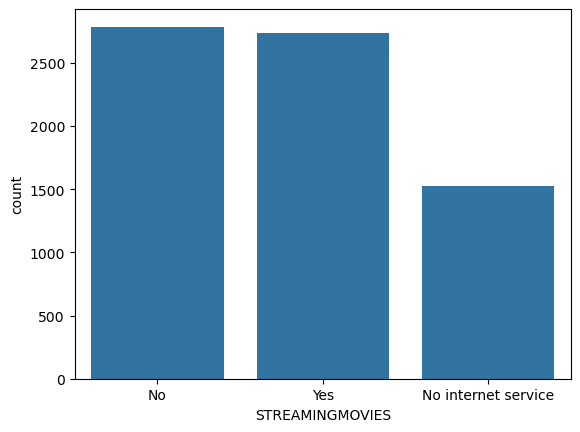

                CONTRACT      Ratio
CONTRACT                           
Month-to-month      3875  55.019168
Two year            1695  24.066449
One year            1473  20.914383
##########################################


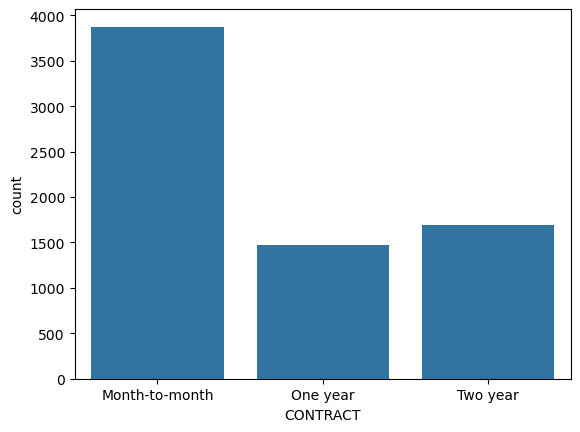

                  PAPERLESSBILLING      Ratio
PAPERLESSBILLING                             
Yes                           4171  59.221922
No                            2872  40.778078
##########################################


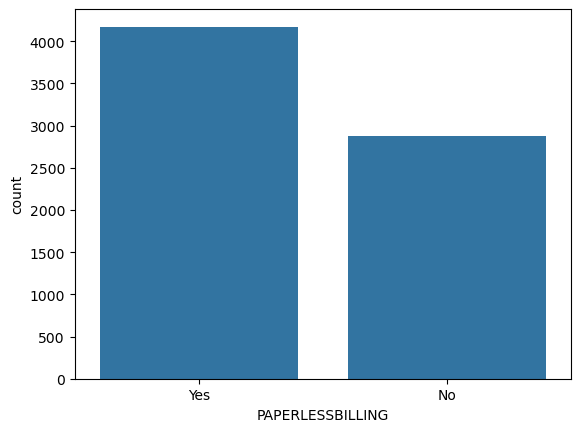

                           PAYMENTMETHOD      Ratio
PAYMENTMETHOD                                      
Electronic check                    2365  33.579441
Mailed check                        1612  22.887974
Bank transfer (automatic)           1544  21.922476
Credit card (automatic)             1522  21.610109
##########################################


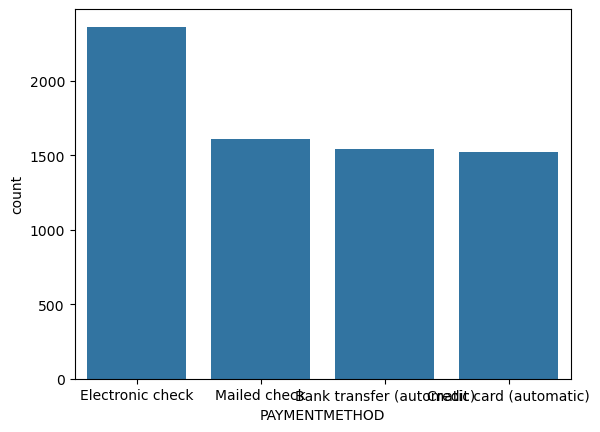

       CHURN      Ratio
CHURN                  
No      5174  73.463013
Yes     1869  26.536987
##########################################


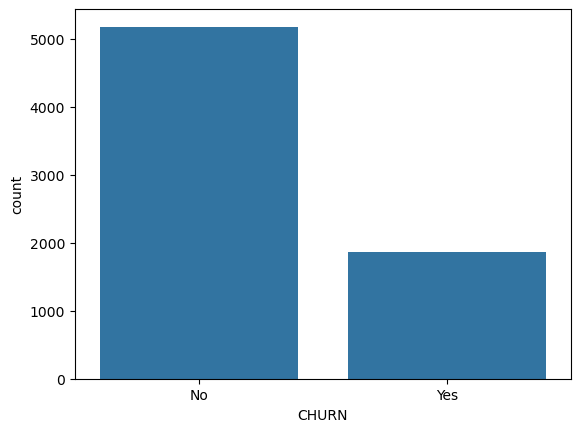

               SENIORCITIZEN      Ratio
SENIORCITIZEN                          
0                       5901  83.785319
1                       1142  16.214681
##########################################


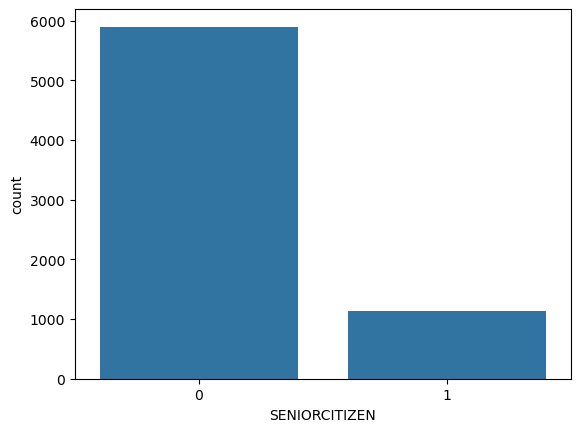

In [31]:
for col in cat_cols:
    cat_summary(df,col,True)

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: TENURE, dtype: float64


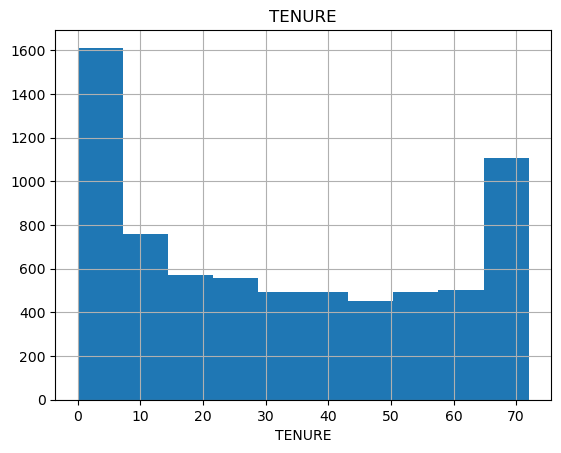

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MONTHLYCHARGES, dtype: float64


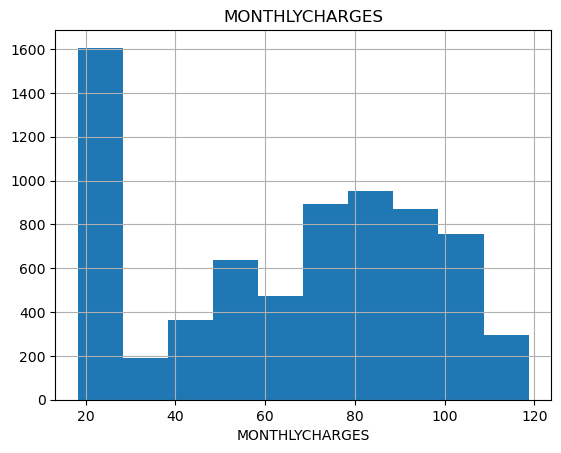

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
5%         48.600000
10%        83.470000
20%       265.320000
30%       548.400000
40%       939.780000
50%      1394.550000
60%      2043.710000
70%      3132.750000
80%      4471.440000
90%      5973.690000
95%      6921.025000
99%      8039.256000
max      8684.800000
Name: TOTALCHARGES, dtype: float64


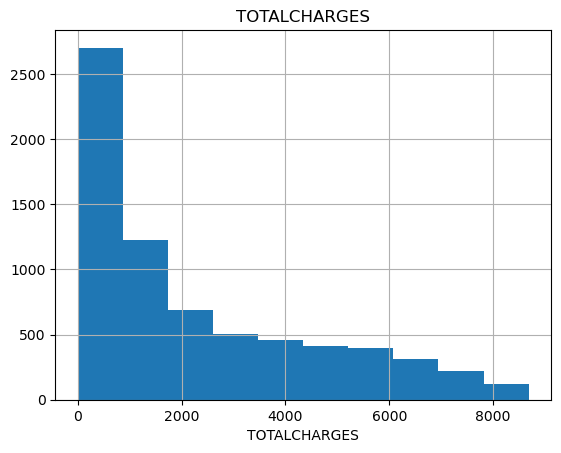

In [32]:
for col in num_cols:
    num_summary(df, col, True)

#### CHURN için Yes/No değerleri 1 ve 0 int değerlere dönüştürüldü

In [33]:
df["CHURN"] = df["CHURN"].map({"Yes": 1, "No": 0})

#### CHRUN hedef değişken olduğu için kategorik değişkenlere göre kırılımlarına bakıldı

In [34]:
for col in cat_cols:
    target_summary_with_cat(df,"CHURN",col)

        TARGET_MEAN
GENDER             
Female     0.269209
Male       0.261603


         TARGET_MEAN
PARTNER             
No          0.329580
Yes         0.196649


            TARGET_MEAN
DEPENDENTS             
No             0.312791
Yes            0.154502


              TARGET_MEAN
PHONESERVICE             
No               0.249267
Yes              0.267096


                  TARGET_MEAN
MULTIPLELINES                
No                   0.250442
No phone service     0.249267
Yes                  0.286099


                 TARGET_MEAN
INTERNETSERVICE             
DSL                 0.189591
Fiber optic         0.418928
No                  0.074050


                     TARGET_MEAN
ONLINESECURITY                  
No                      0.417667
No internet service     0.074050
Yes                     0.146112


                     TARGET_MEAN
ONLINEBACKUP                    
No                      0.399288
No internet service     0.074050
Yes                     0.2153

#### Bazı değişkenlerin INTERSERVICE değişkeni ile bağlantısı olduğu görüldü.

In [35]:
# NOT: İnternet Servisi olmayanların; 
# ONLINESECURITY, 
# ONLINEBACKUP, 
# DEVICEPROTECTION, 
# TECHSUPPORT, 
# STREAMINGTV, 
# STREAMINGMOVIES servisleri de yok.	

In [36]:
df.loc[(df["INTERNETSERVICE"] == "No"),["ONLINESECURITY","ONLINEBACKUP","DEVICEPROTECTION","TECHSUPPORT","STREAMINGTV","STREAMINGMOVIES"]]

,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES
11,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
16,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
21,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
22,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
33,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
...,...,...,...,...,...,...
7017,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
7019,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
7020,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
7030,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service


In [37]:
df.loc[(df["INTERNETSERVICE"] == "No"),["ONLINESECURITY","ONLINEBACKUP","DEVICEPROTECTION","TECHSUPPORT","STREAMINGTV","STREAMINGMOVIES"]] = "No"

In [38]:
change_list = ["ONLINESECURITY","ONLINEBACKUP","DEVICEPROTECTION","TECHSUPPORT","STREAMINGTV","STREAMINGMOVIES"]

In [39]:
df[change_list]

,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES
0,No,Yes,No,No,No,No
1,Yes,No,Yes,No,No,No
2,Yes,Yes,No,No,No,No
3,Yes,No,Yes,Yes,No,No
4,No,No,No,No,No,No
...,...,...,...,...,...,...
7038,Yes,No,Yes,Yes,Yes,Yes
7039,No,Yes,Yes,No,Yes,Yes
7040,Yes,No,No,No,No,No
7041,No,No,No,No,No,No


In [40]:
df.loc[(df["INTERNETSERVICE"] == "No"),"CHURN"].value_counts()

CHURN
0    1413
1     113
Name: count, dtype: int64

#### Kategorik değişkenlerin benzersiz sınıf sayıları döndürüldü.

In [41]:
for col in cat_cols:
    print(col, df[col].nunique())

GENDER 2
PARTNER 2
DEPENDENTS 2
PHONESERVICE 2
MULTIPLELINES 3
INTERNETSERVICE 3
ONLINESECURITY 2
ONLINEBACKUP 2
DEVICEPROTECTION 2
TECHSUPPORT 2
STREAMINGTV 2
STREAMINGMOVIES 2
CONTRACT 3
PAPERLESSBILLING 2
PAYMENTMETHOD 4
CHURN 2
SENIORCITIZEN 2


#### Burada  Yes/No değerleri değişkenleri listeledik ve 1-0 formtatına çektik.

In [42]:
binary = [col for col in cat_cols if (df[col].nunique() == 2) & (col not in ["GENDER","CHURN","SENIORCITIZEN"])]
binary

['PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'PAPERLESSBILLING']

In [43]:
df[binary]

,PARTNER,DEPENDENTS,PHONESERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,PAPERLESSBILLING
0,Yes,No,No,No,Yes,No,No,No,No,Yes
1,No,No,Yes,Yes,No,Yes,No,No,No,No
2,No,No,Yes,Yes,Yes,No,No,No,No,Yes
3,No,No,No,Yes,No,Yes,Yes,No,No,No
4,No,No,Yes,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...
7038,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,Yes
7040,Yes,Yes,No,Yes,No,No,No,No,No,Yes
7041,Yes,No,Yes,No,No,No,No,No,No,Yes


In [44]:
for col in binary:
    df[col] = df[col].map({"Yes":1,"No":0}).astype("Int64")
df[binary]

,PARTNER,DEPENDENTS,PHONESERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,PAPERLESSBILLING
0,1,0,0,0,1,0,0,0,0,1
1,0,0,1,1,0,1,0,0,0,0
2,0,0,1,1,1,0,0,0,0,1
3,0,0,0,1,0,1,1,0,0,0
4,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
7038,1,1,1,1,0,1,1,1,1,1
7039,1,1,1,0,1,1,0,1,1,1
7040,1,1,0,1,0,0,0,0,0,1
7041,1,0,1,0,0,0,0,0,0,1


In [45]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,Female,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [46]:
for col in cat_cols:
    print(col, df[col].nunique())

GENDER 2
PARTNER 2
DEPENDENTS 2
PHONESERVICE 2
MULTIPLELINES 3
INTERNETSERVICE 3
ONLINESECURITY 2
ONLINEBACKUP 2
DEVICEPROTECTION 2
TECHSUPPORT 2
STREAMINGTV 2
STREAMINGMOVIES 2
CONTRACT 3
PAPERLESSBILLING 2
PAYMENTMETHOD 4
CHURN 2
SENIORCITIZEN 2


#### PHONESERVİCİ sıfır olanların MULTIPLİNES değişkeninde değerler "Phone Service" görüldüğü için değerler sadece No olarak dönüştü. Sonra 1-0 dönüşümü yapıldı.

In [47]:
df.loc[(df["PHONESERVICE"] == 0),"MULTIPLELINES"]

0       No phone service
3       No phone service
7       No phone service
20      No phone service
27      No phone service
              ...       
7003    No phone service
7007    No phone service
7029    No phone service
7036    No phone service
7040    No phone service
Name: MULTIPLELINES, Length: 682, dtype: object

In [48]:
df.loc[(df["PHONESERVICE"] == 0),"MULTIPLELINES"] = "No"

In [49]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,Female,0,1,0,1,0,No,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [50]:
df["MULTIPLELINES"] = df["MULTIPLELINES"].map({"Yes":1,"No":0})

In [51]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,Female,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


#### Sayısal değişkenleri için (0.25-0.75 bazında) aykırı değer analizi yapıldı. Aykırı değer görülmedi.

In [52]:
for col in num_cols:
    print(col, check_outlier(df,col))

TENURE False
MONTHLYCHARGES False
TOTALCHARGES False


#### Nadir değişken analizi yapıldı. Nadir değerler görülmedi

In [53]:
rare_analyser(df,"CHURN",cat_cols)

GENDER : 2
        COUNT     RATIO  TARGET_MEAN
GENDER                              
Female   3488  0.495244     0.269209
Male     3555  0.504756     0.261603


PARTNER : 2
         COUNT     RATIO  TARGET_MEAN
PARTNER                              
0         3641  0.516967     0.329580
1         3402  0.483033     0.196649


DEPENDENTS : 2
            COUNT     RATIO  TARGET_MEAN
DEPENDENTS                              
0            4933  0.700412     0.312791
1            2110  0.299588     0.154502


PHONESERVICE : 2
              COUNT     RATIO  TARGET_MEAN
PHONESERVICE                              
0               682  0.096834     0.249267
1              6361  0.903166     0.267096


MULTIPLELINES : 2
               COUNT     RATIO  TARGET_MEAN
MULTIPLELINES                              
0               4072  0.578163     0.250246
1               2971  0.421837     0.286099


INTERNETSERVICE : 3
                 COUNT     RATIO  TARGET_MEAN
INTERNETSERVICE                        

#### Eşsiz sınıf sayısına bakıldı. Ve GENDER değişkeni label encoding işlemine tabi tutuldu.

In [54]:
for col in df.columns:
    print(col, df[col].nunique())

GENDER 2
SENIORCITIZEN 2
PARTNER 2
DEPENDENTS 2
TENURE 73
PHONESERVICE 2
MULTIPLELINES 2
INTERNETSERVICE 3
ONLINESECURITY 2
ONLINEBACKUP 2
DEVICEPROTECTION 2
TECHSUPPORT 2
STREAMINGTV 2
STREAMINGMOVIES 2
CONTRACT 3
PAPERLESSBILLING 2
PAYMENTMETHOD 4
MONTHLYCHARGES 1585
TOTALCHARGES 6531
CHURN 2


In [55]:
df[[col for col in df.columns if df[col].nunique() == 2]]

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,PAPERLESSBILLING,CHURN
0,Female,0,1,0,0,0,0,1,0,0,0,0,1,0
1,Male,0,0,0,1,0,1,0,1,0,0,0,0,0
2,Male,0,0,0,1,0,1,1,0,0,0,0,1,1
3,Male,0,0,0,0,0,1,0,1,1,0,0,0,0
4,Female,0,0,0,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,1,1,1,1,1,0,1,1,1,1,1,0
7039,Female,0,1,1,1,1,0,1,1,0,1,1,1,0
7040,Female,0,1,1,0,0,1,0,0,0,0,0,1,0
7041,Male,1,1,0,1,1,0,0,0,0,0,0,1,1


In [56]:
label_encoder(df,"GENDER")

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,DSL,1,0,1,1,1,1,One year,1,Mailed check,84.80,1990.50,0
7039,0,0,1,1,72,1,1,Fiber optic,0,1,1,0,1,1,One year,1,Credit card (automatic),103.20,7362.90,0
7040,0,0,1,1,11,0,0,DSL,1,0,0,0,0,0,Month-to-month,1,Electronic check,29.60,346.45,0
7041,1,1,1,0,4,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Mailed check,74.40,306.60,1


In [57]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


#### Birden fazla sınıfa sahip değişkenlere one hot encoding uygulandı. 1-0 dönüşümü yapıldı.

In [58]:
ohc = ["INTERNETSERVICE","CONTRACT","PAYMENTMETHOD"]
df[ohc]

,INTERNETSERVICE,CONTRACT,PAYMENTMETHOD
0,DSL,Month-to-month,Electronic check
1,DSL,One year,Mailed check
2,DSL,Month-to-month,Mailed check
3,DSL,One year,Bank transfer (automatic)
4,Fiber optic,Month-to-month,Electronic check
...,...,...,...
7038,DSL,One year,Mailed check
7039,Fiber optic,One year,Credit card (automatic)
7040,DSL,Month-to-month,Electronic check
7041,Fiber optic,Month-to-month,Mailed check


In [59]:
df = one_hot_encoder(df,ohc,True)

In [60]:
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,False,False,True,False,False,False,True
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,False,False,True,False,False,False,False
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,True,False,False,False,False,True,False


In [61]:
bool_to_int = [col for col in df.columns if df[col].dtype == bool]
df[bool_to_int]

,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
0,False,False,False,False,False,True,False
1,False,False,True,False,False,False,True
2,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False
4,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...
7038,False,False,True,False,False,False,True
7039,True,False,True,False,True,False,False
7040,False,False,False,False,False,True,False
7041,True,False,False,False,False,False,True


In [62]:
for col in bool_to_int:
    df[col] = df[col].map({True:1,False:0})
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,0,1,0


#### Sayısal değişkenler için MinMax Scaling işlemi uygulandı.

In [63]:
mms = MinMaxScaler()
df[num_cols] = mms.fit_transform(df[num_cols])
df.head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
0,0,0,1,0,0.013889,0,0,0,1,0,0,0,0,1,0.115423,0.003437,0,0,0,0,0,0,1,0
1,1,0,0,0,0.472222,1,0,1,0,1,0,0,0,0,0.385075,0.217564,0,0,0,1,0,0,0,1
2,1,0,0,0,0.027778,1,0,1,1,0,0,0,0,1,0.354229,0.012453,1,0,0,0,0,0,0,1
3,1,0,0,0,0.625000,0,0,1,0,1,1,0,0,0,0.239303,0.211951,0,0,0,1,0,0,0,0
4,0,0,0,0,0.027778,1,0,0,0,0,0,0,0,1,0.521891,0.017462,1,1,0,0,0,0,1,0


#### EDA süreci tamam. Veriseti modellenmeye hazır.

In [64]:
y = df["CHURN"]
X = df.drop("CHURN",axis=1)

In [65]:
X, y

(      GENDER  SENIORCITIZEN  PARTNER  DEPENDENTS    TENURE  PHONESERVICE  MULTIPLELINES  ONLINESECURITY  ONLINEBACKUP  DEVICEPROTECTION  TECHSUPPORT  STREAMINGTV  STREAMINGMOVIES  PAPERLESSBILLING  MONTHLYCHARGES  TOTALCHARGES  INTERNETSERVICE_Fiber optic  INTERNETSERVICE_No  CONTRACT_One year  CONTRACT_Two year  PAYMENTMETHOD_Credit card (automatic)  PAYMENTMETHOD_Electronic check  PAYMENTMETHOD_Mailed check
 0          0              0        1           0  0.013889             0              0               0             1                 0            0            0                0                 1        0.115423      0.003437                            0                   0                  0                  0                                      0                               1                           0
 1          1              0        0           0  0.472222             1              0               1             0                 1            0            0          

## MACHİNE LEARNİNG (ML)

### Train-Test Veri Seti Bölünmesi

In [66]:
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=11)

In [67]:
X_train

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check
5305,0,0,1,0,0.597222,1,0,1,0,1,1,1,1,1,0.602488,0.398432,0,0,0,1,0,1,0
3351,0,0,0,0,0.222222,1,0,0,1,0,1,0,0,1,0.354726,0.096047,0,0,0,0,0,0,1
5177,1,1,1,0,0.500000,1,1,0,0,0,0,0,1,1,0.655224,0.347918,1,0,0,0,0,1,0
1460,1,0,0,0,0.069444,1,1,0,1,1,0,0,0,1,0.667164,0.048838,1,0,0,0,0,1,0
4010,0,0,0,0,0.013889,1,0,0,0,0,0,0,0,0,0.021393,0.002349,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,1,0,1,1,0.930556,1,1,0,1,1,1,1,1,1,0.924876,0.867124,1,0,0,1,0,0,0
4023,1,0,0,0,0.583333,1,0,0,0,0,0,0,0,0,0.015423,0.097861,0,1,1,0,0,0,0
5200,0,0,1,1,0.972222,1,1,0,1,1,0,1,1,1,0.878109,0.851718,1,0,1,0,0,1,0
3775,1,1,0,0,0.569444,1,1,0,0,1,0,1,1,1,0.797512,0.482193,1,0,0,0,0,1,0


### Logistic Regression (LR)

#### Model Eğitimi

In [68]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)


LogisticRegression()

#### İlk Tahminleme ve Hatalar

In [69]:
y_pred_lr = lr_model.predict(X_test)

In [70]:
check_errors(lr_model,X_test,y_test,y_pred_lr)

 Model LogisticRegression()
        Accuracy : 0.8006
        Precision: 0.6550
        Recall   : 0.5423
        F1       : 0.5933
        ROC AUC  : 0.8527
        Log Loss : 0.4106
        


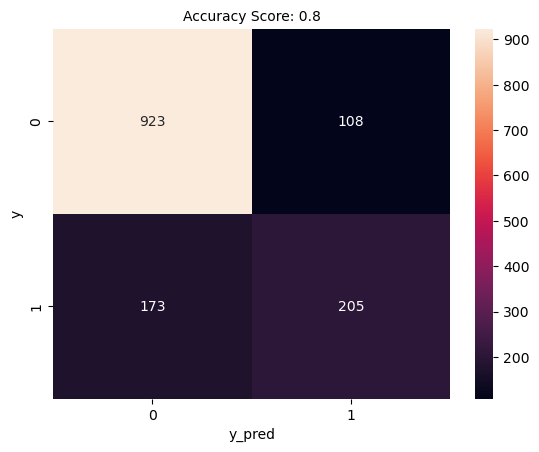

In [71]:
plot_confusion_matrix(y_test, y_pred_lr)

#### Cross-Validate (Çapraz Doğrulama)

In [72]:
cv_results = cross_validate(
    lr_model, X, y,
    cv=5,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"]
)

In [73]:
cv_result_printer(cv_results)

Accuracy:   0.8028
Precision:  0.6535
Recall:     0.5463
F1:       0.5950
ROC AUC:    0.8447


#### GridSearchCV (Hiperparametre Optimizasyonu)

In [74]:
param_grid = [
    # lbfgs/newton-cg/sag: l2 veya none
    {"solver": ["lbfgs", "newton-cg", "sag"],
     "C": [0.01, 0.1, 1, 10]},

    # liblinear: l1 veya l2
    {"solver": ["liblinear"],
     "C": [0.01, 0.1, 1, 10]},

    # saga: l1, l2, elasticnet veya none (elasticnet için l1_ratio zorunlu)
    {"solver": ["saga"],
     "l1_ratio": [0.1, 0.5, 0.9],
     "C": [0.01, 0.1, 1, 10]}
]

In [75]:
grid_search = GridSearchCV(
    lr_model, param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X, y)
print("Best Params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Best Params: {'C': 10, 'solver': 'sag'}
Best ROC-AUC: 0.845469794938167


#### Final Model

In [76]:
lr_final = grid_search.best_estimator_

In [77]:
final_pred_lr = lr_final.predict(X_test)
check_errors(lr_final,X_test,y_test,final_pred_lr)

 Model LogisticRegression(C=10, solver='sag')
        Accuracy : 0.8013
        Precision: 0.6561
        Recall   : 0.5450
        F1       : 0.5954
        ROC AUC  : 0.8553
        Log Loss : 0.4078
        


### K-Nearest Neighbors (KNN)

#### Model Eğitimi

In [78]:
knn_model = KNeighborsClassifier().fit(X_train,y_train)

#### İlk Tahminleme ve Hatalar

In [79]:
y_pred_knn = knn_model.predict(X_test)

In [80]:
check_errors(knn_model,X_test,y_test,y_pred_knn)

 Model KNeighborsClassifier()
        Accuracy : 0.7857
        Precision: 0.6056
        Recall   : 0.5767
        F1       : 0.5908
        ROC AUC  : 0.7909
        Log Loss : 1.7589
        


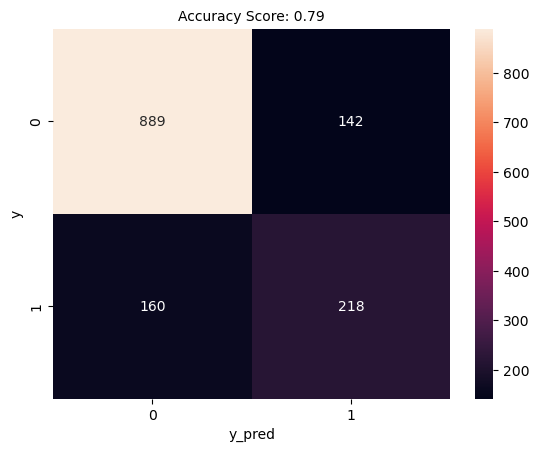

In [81]:
plot_confusion_matrix(y_test, y_pred_knn)

#### Cross-Validate (Çapraz Doğrulama)

In [82]:
cv_results = cross_validate(
    knn_model, X, y,
    cv=5,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"]
)

In [83]:
cv_result_printer(cv_results)

Accuracy:   0.7681
Precision:  0.5680
Recall:     0.5281
F1:       0.5472
ROC AUC:    0.7769


#### GridSearchCV (Hiperparametre Optimizasyonu)

In [84]:
grid_params = {"n_neighbors": range(2, 50)}

In [85]:
grid_search = GridSearchCV(
    knn_model,grid_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
grid_search.fit(X,y)
print("Best Params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Best Params: {'n_neighbors': 48}
Best ROC-AUC: 0.8324479036048039


#### Final Model

In [86]:
knn_final = grid_search.best_estimator_
finall_pred_knn = knn_final.predict(X_test)

In [87]:
check_errors(knn_final,X_test,y_test,finall_pred_knn)

 Model KNeighborsClassifier(n_neighbors=48)
        Accuracy : 0.8077
        Precision: 0.6588
        Recall   : 0.5873
        F1       : 0.6210
        ROC AUC  : 0.8636
        Log Loss : 0.4027
        


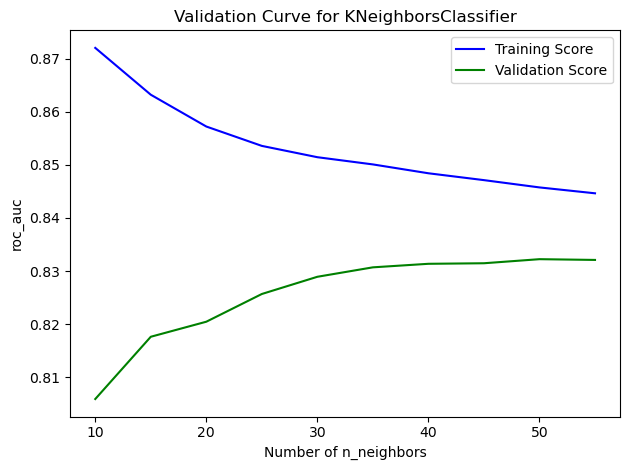

In [88]:
val_curve_params(knn_final,X,y,"n_neighbors",range(10,60,5),scoring="roc_auc",cv=5)

### DecisionTreeClassifier (DTC)

In [89]:
dtc_model = DecisionTreeClassifier().fit(X_train,y_train)

#### İlk Tahminler ve Hatalar

In [90]:
y_pred_dtc = dtc_model.predict(X_test)

In [91]:
check_errors(dtc_model,X_test,y_test,y_pred_dtc)

 Model DecisionTreeClassifier()
        Accuracy : 0.7374
        Precision: 0.5099
        Recall   : 0.5476
        F1       : 0.5281
        ROC AUC  : 0.6780
        Log Loss : 9.4166
        


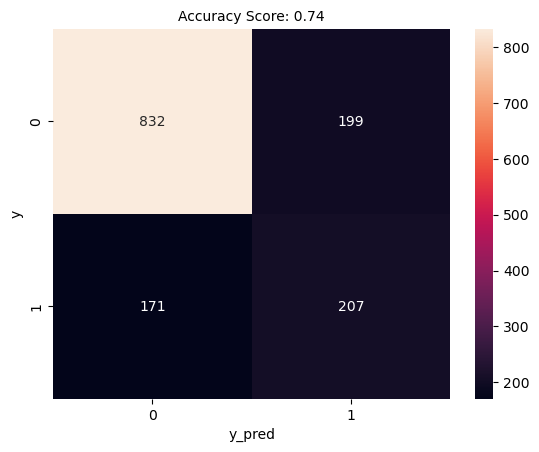

In [92]:
plot_confusion_matrix(y_test, y_pred_dtc)

#### Cross-Validate (Çapraz Doğrulama)

In [93]:
cv_results = cross_validate(dtc_model,
                            X,y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])


In [94]:
cv_result_printer(cv_results)

Accuracy:   0.7204
Precision:  0.4738
Recall:     0.4815
F1:       0.4775
ROC AUC:    0.6448


#### GridSearchCV (Hiperparametre Optimizasyonu)

In [95]:
grid_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

In [96]:
grid_search = GridSearchCV(
    dtc_model,grid_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
).fit(X,y)
print("Best Params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Best Params: {'max_depth': 5, 'min_samples_split': 9}
Best ROC-AUC: 0.8250174748509446


#### Final Model

In [97]:
dtc_final = grid_search.best_estimator_
finall_pred_dtc = dtc_final.predict(X_test)

In [98]:
check_errors(dtc_final,X_test,y_test,finall_pred_dtc)

 Model DecisionTreeClassifier(max_depth=5, min_samples_split=9)
        Accuracy : 0.8020
        Precision: 0.6387
        Recall   : 0.6032
        F1       : 0.6204
        ROC AUC  : 0.8532
        Log Loss : 0.4070
        


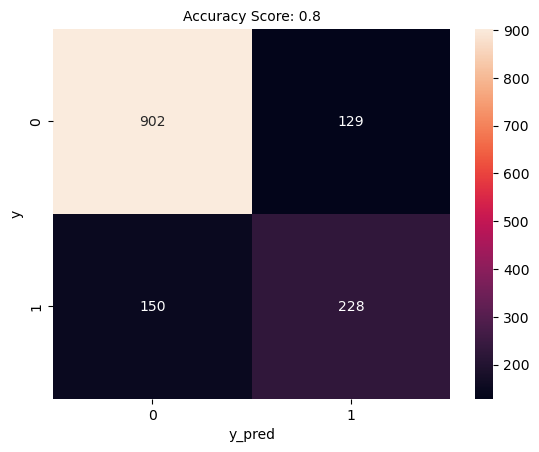

In [99]:
plot_confusion_matrix(y_test, finall_pred_dtc)

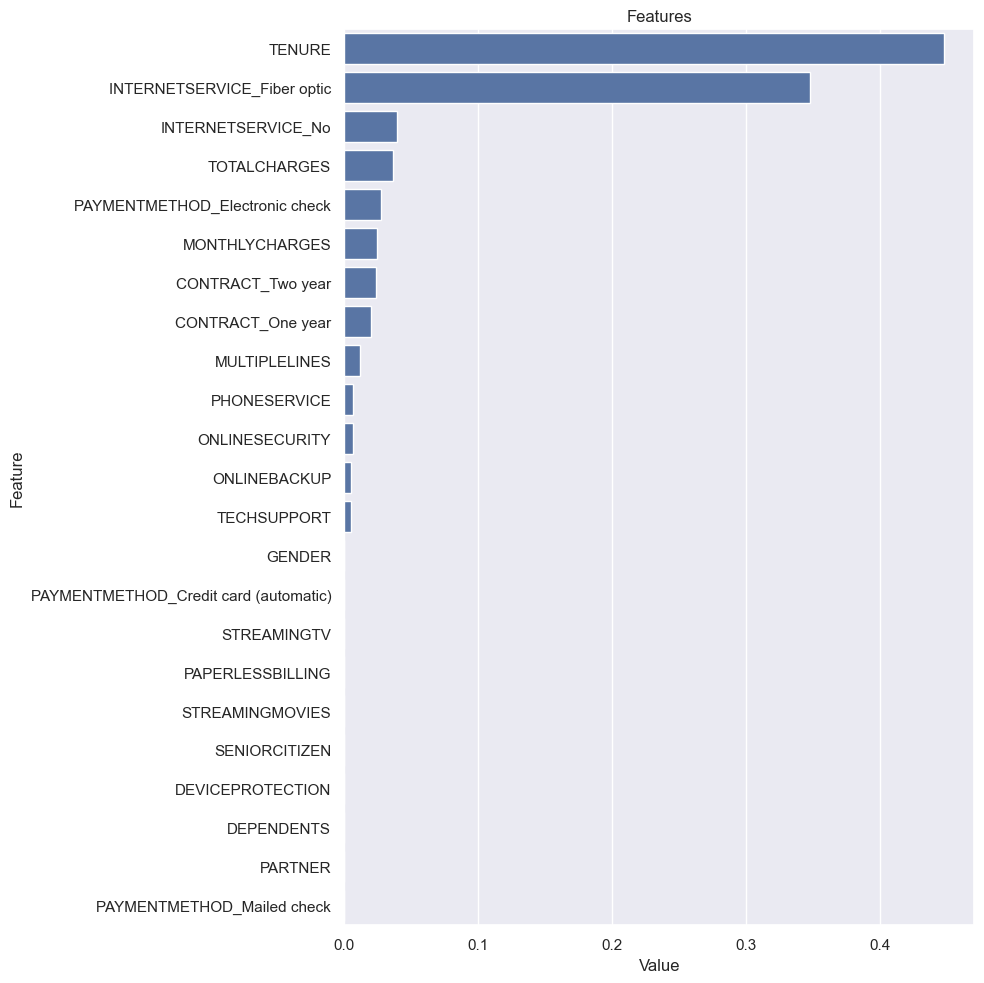

In [100]:
plot_importance(dtc_final, X,X.shape[1])

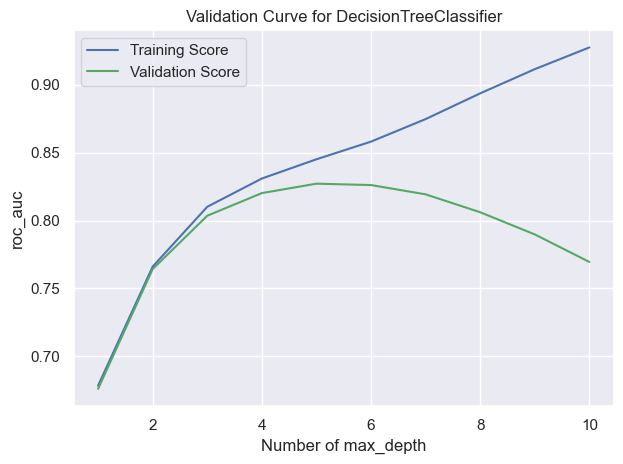

In [101]:
val_curve_params(dtc_final,X,y,"max_depth",range(1,11),scoring="roc_auc")

In [102]:
tree_graph(dtc_final,df.drop("CHURN",axis=1).columns,"rfc_final.png")

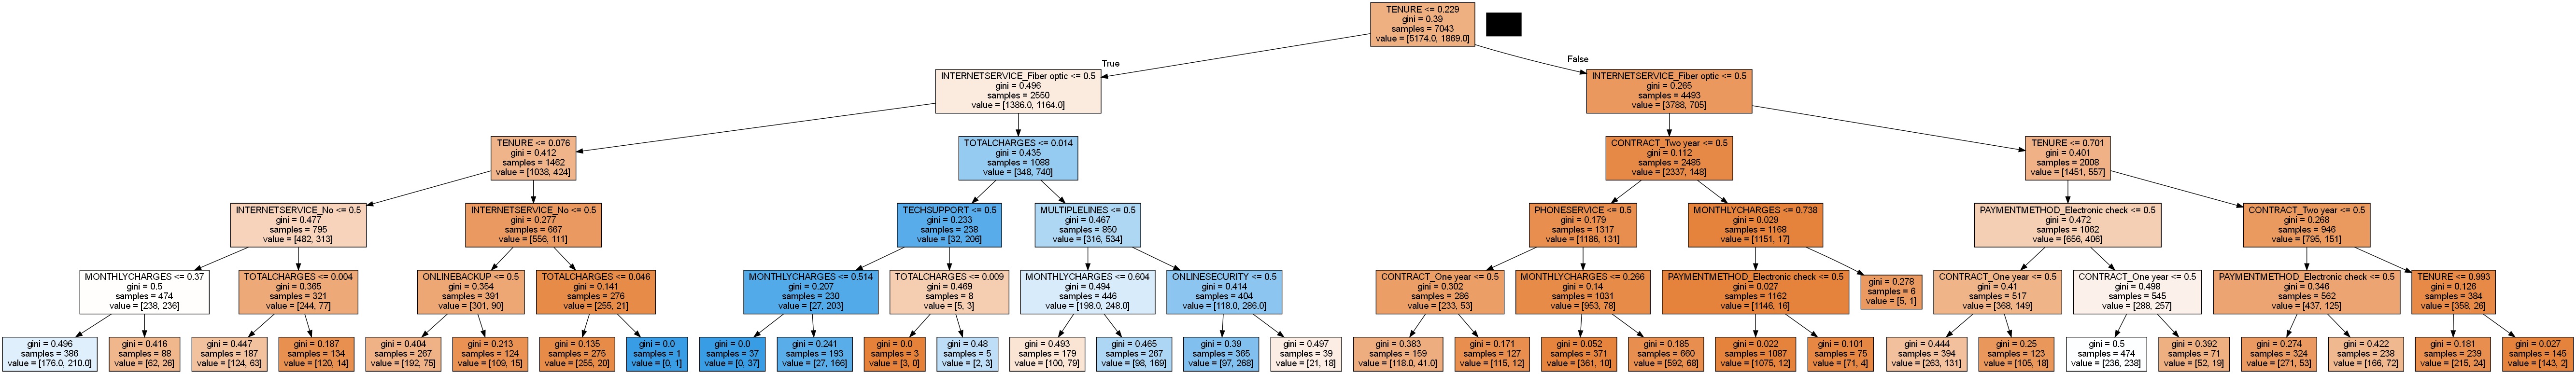

### RandomForestClassifier (RFC)

#### Model Eğitimi

In [103]:
rfc_model = RandomForestClassifier().fit(X_train,y_train)

#### İlk Tahminler ve Hatalar

In [104]:
y_pred_rfc = rfc_model.predict(X_test)
check_errors(rfc_model,X_test,y_test,y_pred_rfc)

 Model RandomForestClassifier()
        Accuracy : 0.7913
        Precision: 0.6533
        Recall   : 0.4735
        F1       : 0.5491
        ROC AUC  : 0.8292
        Log Loss : 0.5291
        


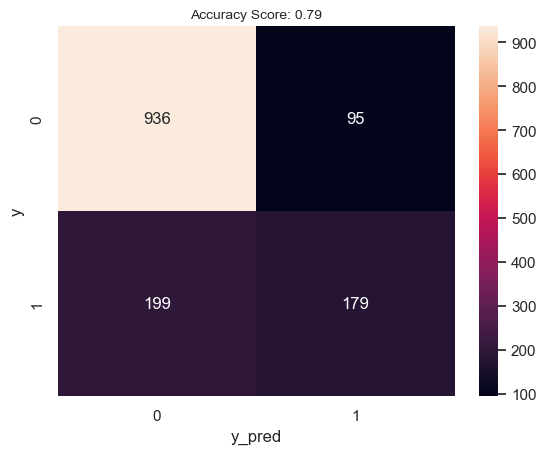

In [105]:
plot_confusion_matrix(y_test, y_pred_rfc)

#### Cross-Validate (Çapraz Doğrulama)

In [106]:
cv_results = cross_validate(rfc_model,
                            X,y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
cv_result_printer(cv_results)

Accuracy:   0.7933
Precision:  0.6460
Recall:     0.4912
F1:       0.5579
ROC AUC:    0.8234


#### GridSearchCV (Hiperparametre Optimizasyonu)

In [107]:
grid_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, "auto"],
             "min_samples_split": [8, 15, 20,25,30],
             "n_estimators": [300,500,700]}

In [108]:
grid_search = GridSearchCV(
    rfc_model,grid_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=3
).fit(X,y)
print("Best Params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Params: {'max_depth': 8, 'max_features': 3, 'min_samples_split': 25, 'n_estimators': 500}
Best ROC-AUC: 0.8473309345358555


#### Final Model

In [109]:
rfc_final = grid_search.best_estimator_
finall_pred_rfc = rfc_final.predict(X_test)

In [110]:
check_errors(rfc_final,X_test,y_test,y_pred_rfc)

 Model RandomForestClassifier(max_depth=8, max_features=3, min_samples_split=25,
                       n_estimators=500)
        Accuracy : 0.7913
        Precision: 0.6533
        Recall   : 0.4735
        F1       : 0.5491
        ROC AUC  : 0.8928
        Log Loss : 0.3749
        


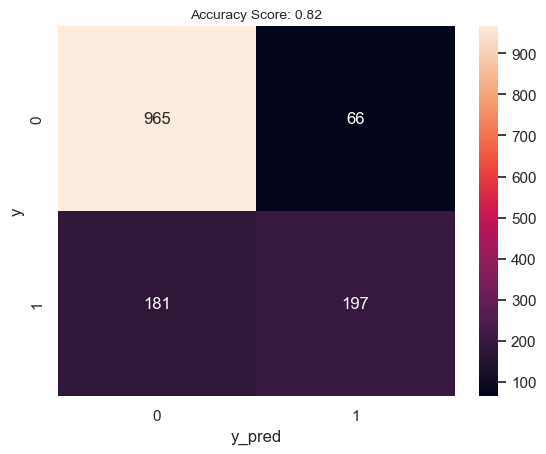

In [111]:
plot_confusion_matrix(y_test,finall_pred_rfc)

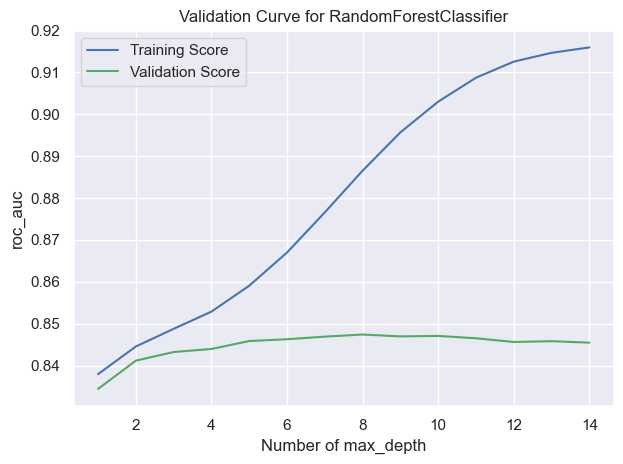

In [112]:
val_curve_params(rfc_final,X,y,"max_depth",range(1,15),scoring="roc_auc",cv=5)


### GradientBoostingMachine (GBM)

#### Model Kurma

In [113]:
gbm_model = GradientBoostingClassifier().fit(X_train,y_train)

#### İlk Tahmin ve Hatalar

In [114]:
y_pred_gbm = gbm_model.predict(X_test)
check_errors(gbm_model,X_test,y_test,y_pred_gbm)

 Model GradientBoostingClassifier()
        Accuracy : 0.8077
        Precision: 0.6851
        Recall   : 0.5238
        F1       : 0.5937
        ROC AUC  : 0.8582
        Log Loss : 0.4038
        


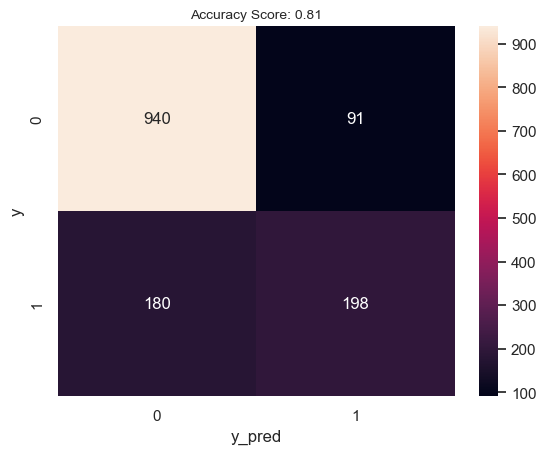

In [115]:
plot_confusion_matrix(y_test,y_pred_gbm)

#### Cross-Validate (Çapraz Doğrulama)

In [116]:
cv_results = cross_validate(gbm_model,
                            X,y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
cv_result_printer(cv_results)

Accuracy:   0.8041
Precision:  0.6651
Recall:     0.5286
F1:       0.5890
ROC AUC:    0.8453


#### GridSearchCV (Hiperparametre Optimizasyonu)

In [117]:
grid_params = {"learning_rate": [0.01,0.1],
             "max_depth": [3, 5, 8, 10],
             "n_estimators": [100,500,1000],
             "subsample":[1,0.5,0.7]}

grid_search = GridSearchCV(
    gbm_model,grid_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=3
).fit(X,y)
print("Best Params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
Best ROC-AUC: 0.8485808960678753


#### Final Model

In [118]:
gbm_final = grid_search.best_estimator_
finall_pred_gbm = gbm_final.predict(X_test)

In [119]:
check_errors(gbm_final,X_test,y_test,finall_pred_gbm)

 Model GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, subsample=0.7)
        Accuracy : 0.8204
        Precision: 0.7224
        Recall   : 0.5370
        F1       : 0.6161
        ROC AUC  : 0.8743
        Log Loss : 0.3879
        


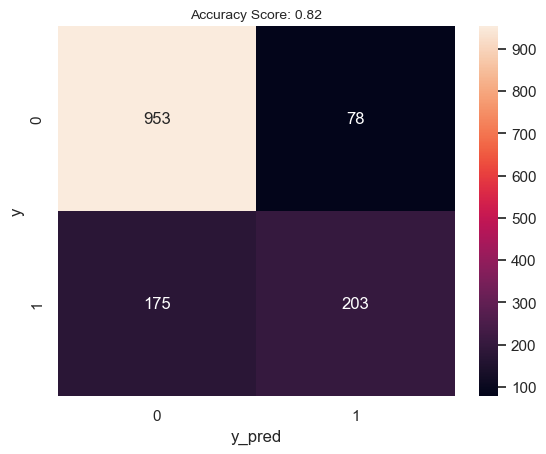

In [120]:
plot_confusion_matrix(y_test,finall_pred_gbm)

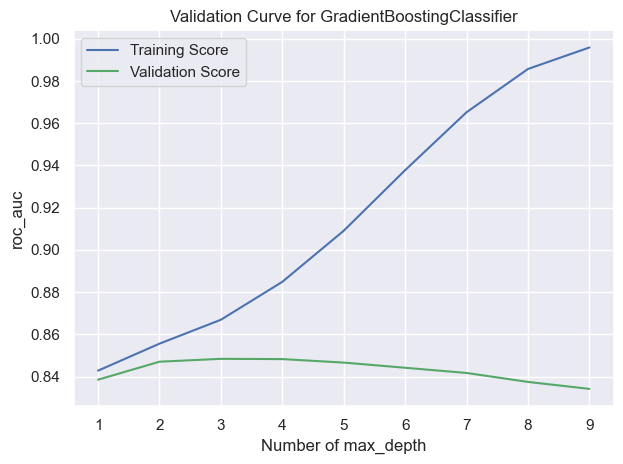

In [121]:
val_curve_params(gbm_final,X,y,"max_depth",range(1,10),scoring="roc_auc",cv=5)

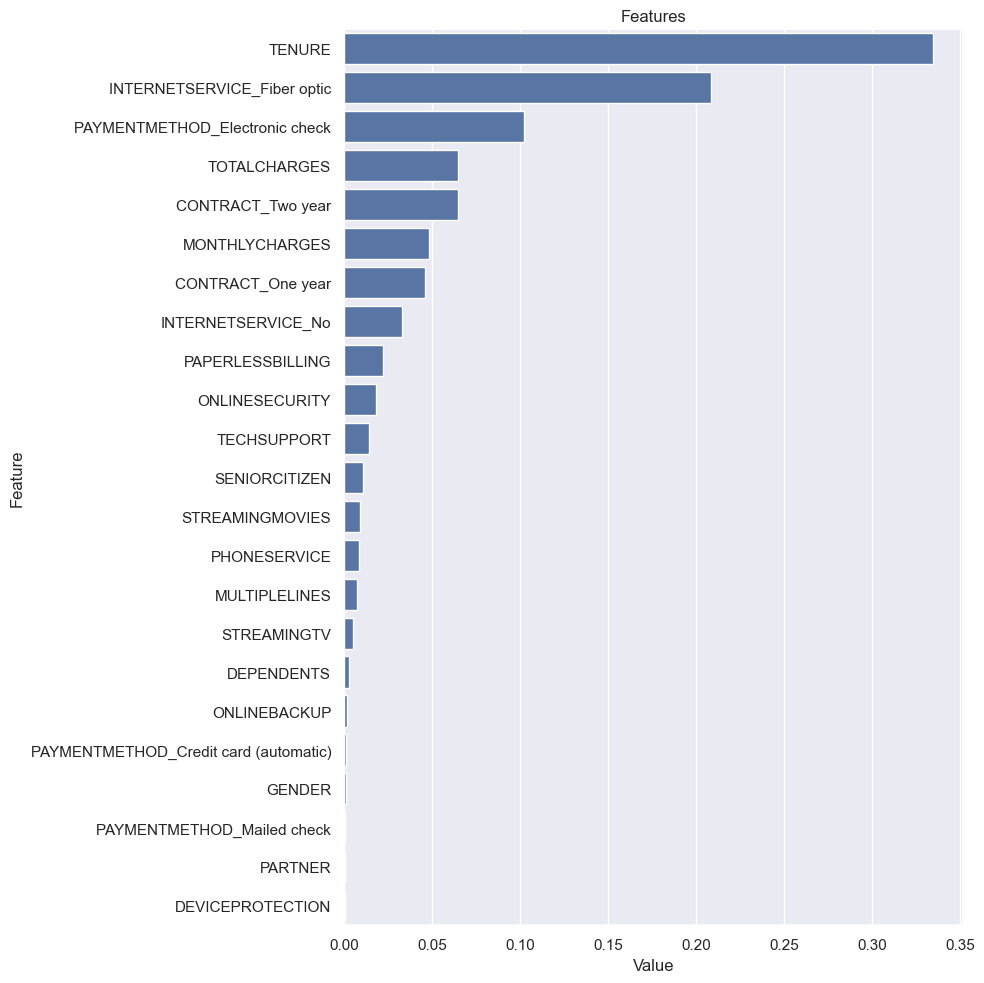

In [122]:
plot_importance(gbm_final,X,X.shape[1])

### XGBOOST (XGB)

#### Model Oluşturma

In [123]:
xgb_model = XGBClassifier().fit(X_train,y_train)

#### İlk Tahmin ve Hatalar

In [124]:
y_pred_xgb = xgb_model.predict(X_test)
check_errors(xgb_model,X_test,y_test,y_pred_xgb)

 Model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
        Accuracy : 0.7850
        Precision: 0.6198
        Recall   : 0.5132
        F1       : 0.5615
        ROC AUC  : 0.8323
        Log Loss : 0.4567
        


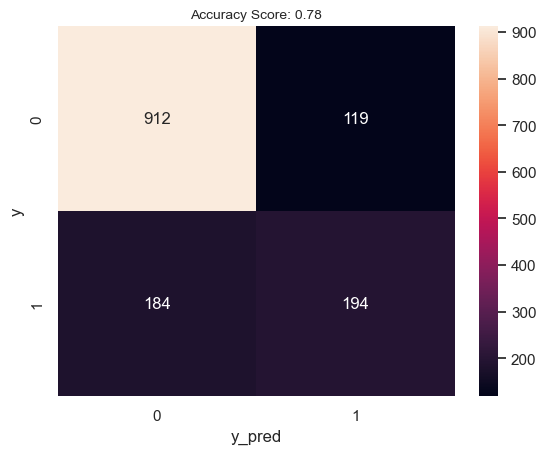

In [125]:
plot_confusion_matrix(y_test,y_pred_xgb)

#### Cross-Validate (Çapraz Doğrulama)

In [126]:
cv_results = cross_validate(xgb_model,
                            X,y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
cv_result_printer(cv_results)

Accuracy:   0.7852
Precision:  0.6136
Recall:     0.5158
F1:       0.5603
ROC AUC:    0.8199


#### GridSearchCV (Hiperparametre Optimizasyonu)

In [127]:
grid_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [3, 5, 8],
                  "n_estimators": [100, 500,700, 1000],
                  "colsample_bytree": [0.3,0.5,0.7,1]}

grid_search = GridSearchCV(
    xgb_model,grid_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=3
).fit(X,y)
print("Best Params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Params: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Best ROC-AUC: 0.849740606388829


#### Final Model

In [128]:
xgb_final = grid_search.best_estimator_
finall_pred_xgb = xgb_final.predict(X_test)

In [129]:
check_errors(xgb_final,X_test,y_test,finall_pred_xgb)

 Model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
        Accuracy : 0.8133
        Precision: 0.6976
        Recall   : 0.5370
        F1       : 0.6069
        ROC AUC  : 0.8754
        Log Loss : 0.3845
        


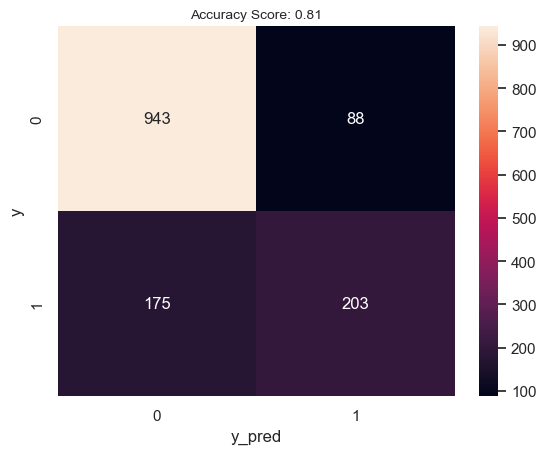

In [130]:
plot_confusion_matrix(y_test,finall_pred_xgb)

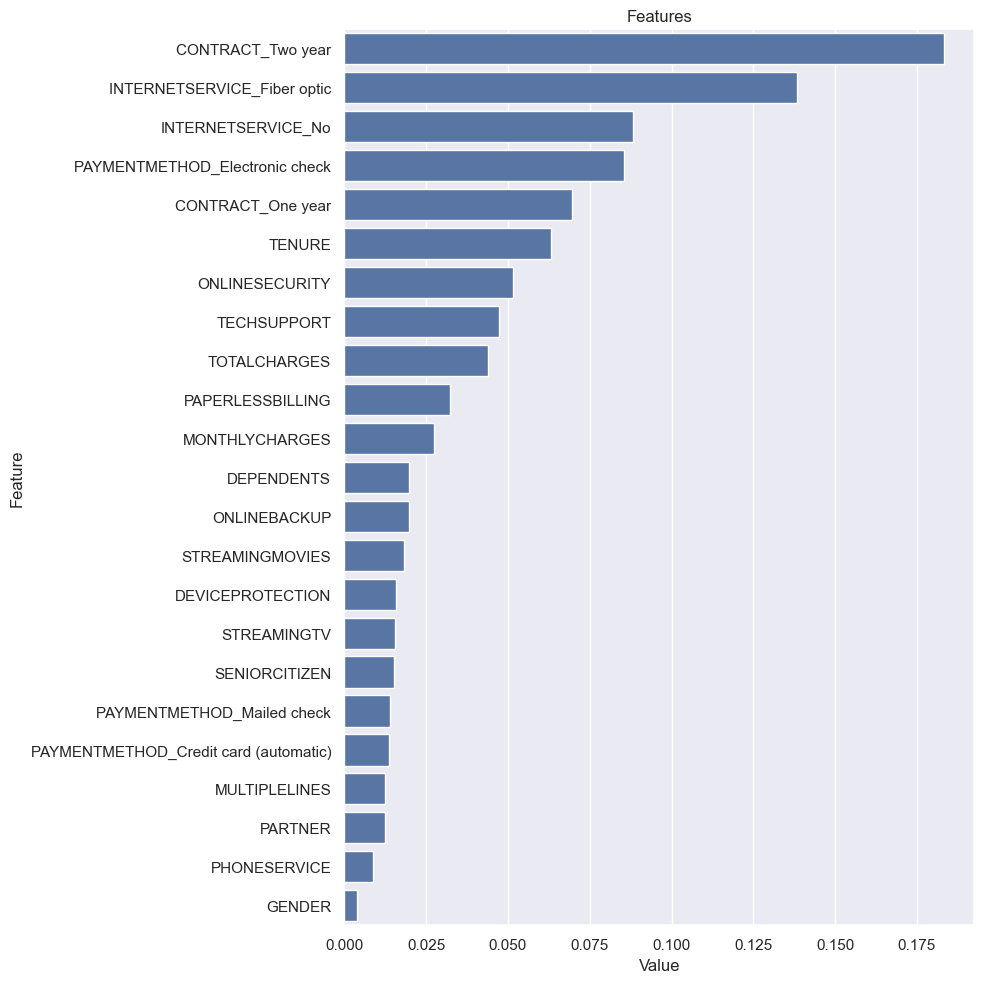

In [131]:
plot_importance(xgb_final,X,X.shape[1])

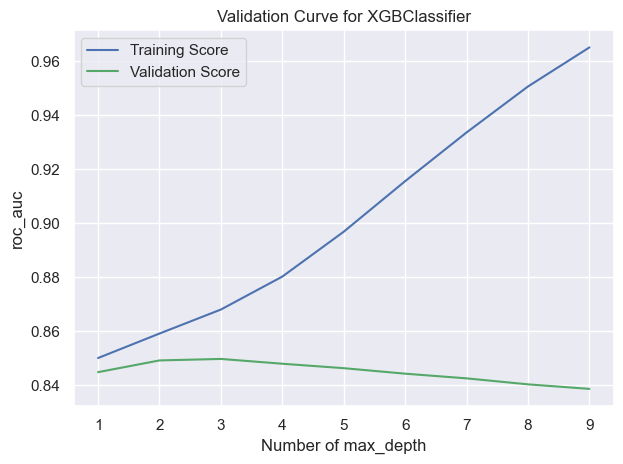

In [132]:
val_curve_params(xgb_final,X,y,"max_depth",range(1,10),"roc_auc",cv=5)

### LightGBM (LGBM)

#### Model Oluşturma

In [133]:
lgbm_model = LGBMClassifier(verbose=-1).fit(X_train,y_train)

#### İlk Tahmin ve Hatalar

In [134]:
y_pred_lgbm = lgbm_model.predict(X_test)
check_errors(lgbm_model,X_test,y_test,y_pred_lgbm)

 Model LGBMClassifier(verbose=-1)
        Accuracy : 0.8034
        Precision: 0.6613
        Recall   : 0.5476
        F1       : 0.5991
        ROC AUC  : 0.8434
        Log Loss : 0.4242
        


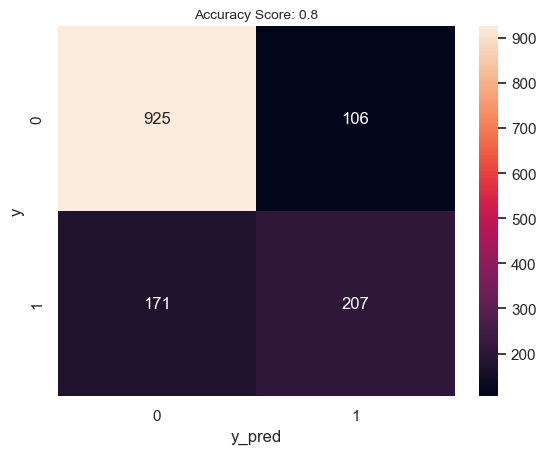

In [135]:
plot_confusion_matrix(y_test,y_pred_lgbm)

#### Cross-Validate (Çapraz Doğrulama)

In [136]:
cv_results = cross_validate(lgbm_model,
                            X,y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
cv_result_printer(cv_results)

Accuracy:   0.7921
Precision:  0.6344
Recall:     0.5158
F1:       0.5685
ROC AUC:    0.8342


#### GridSearchCV (Hiperparametre Optimizasyonu)

In [137]:
grid_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1]}

grid_search = GridSearchCV(
    lgbm_model,grid_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=3
).fit(X,y)
print("Best Params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'n_estimators': 200}
Best ROC-AUC: 0.8460779275272594


#### Final Model

In [138]:
lgbm_final = grid_search.best_estimator_
final_pred_lgbm = lgbm_final.predict(X_test)
check_errors(lgbm_final,X_test,y_test,final_pred_lgbm)

 Model LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, n_estimators=200,
               verbose=-1)
        Accuracy : 0.8261
        Precision: 0.7548
        Recall   : 0.5212
        F1       : 0.6166
        ROC AUC  : 0.8871
        Log Loss : 0.3844
        


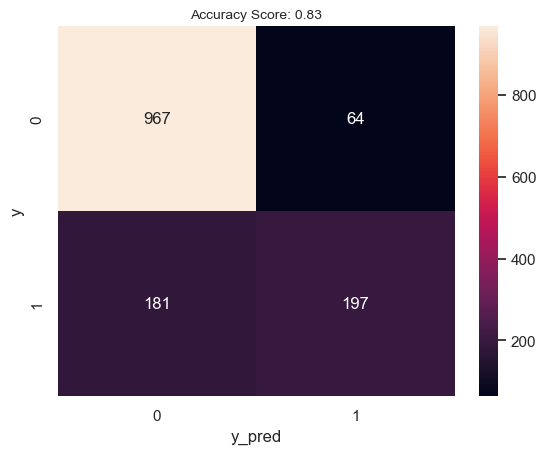

In [139]:
plot_confusion_matrix(y_test,final_pred_lgbm)

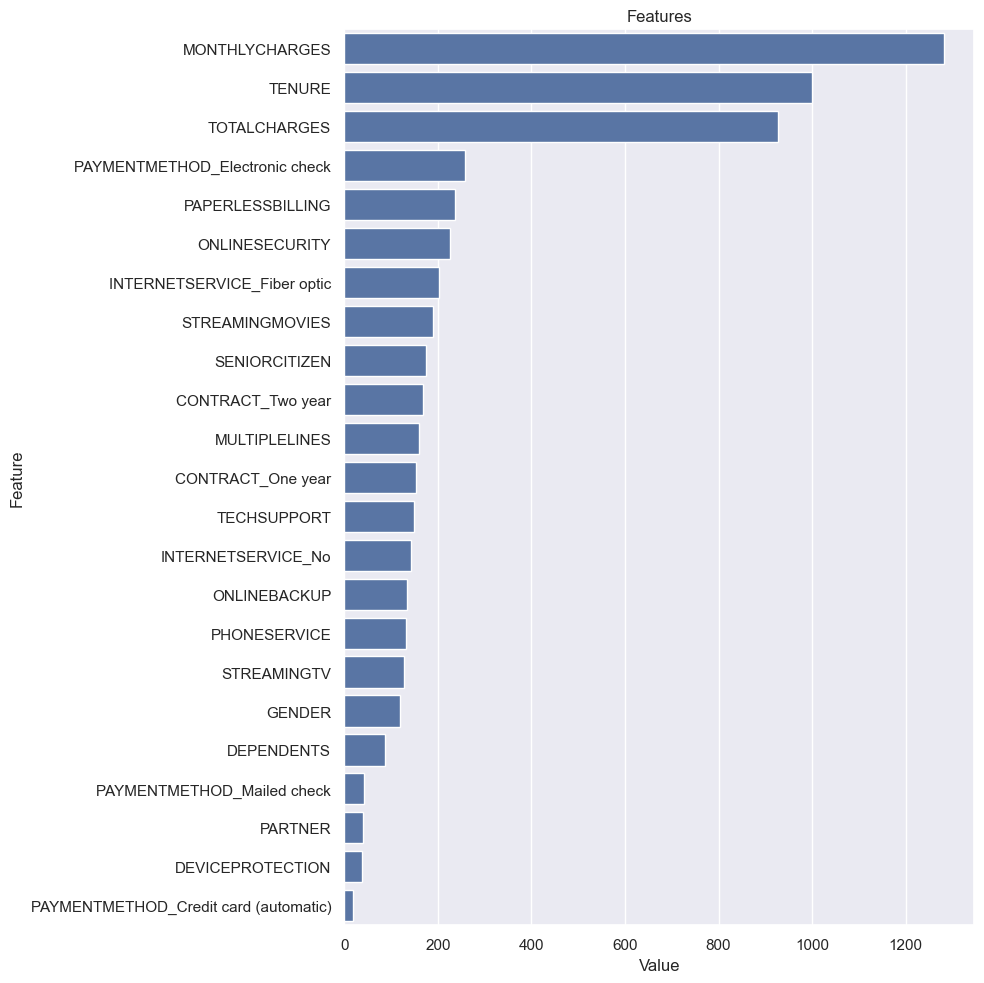

In [140]:
plot_importance(lgbm_final,X,X.shape[1])

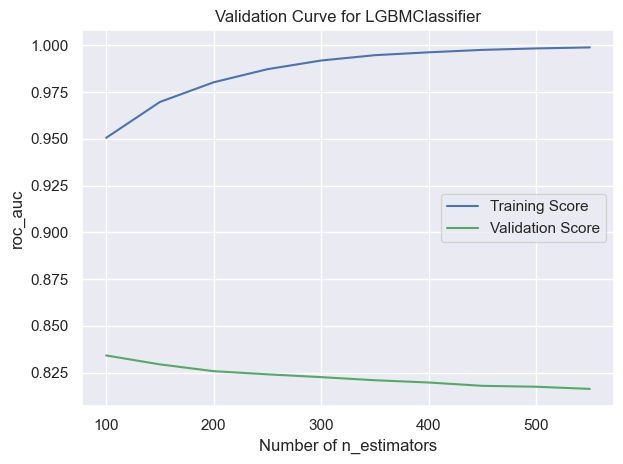

In [141]:
val_curve_params(lgbm_model,X,y,"n_estimators",range(100,600,50),cv=5)

### CatBoost (CB)

#### Model Oluşturma

In [142]:
cb_model = CatBoostClassifier(verbose=False).fit(X_train,y_train)

#### İlk Tahmin Ve Hatalar

In [143]:
y_pred_cb = cb_model.predict(X_test)
check_errors(cb_model,X_test,y_test,y_pred_cb)

 Model <catboost.core.CatBoostClassifier object at 0x000001CBAADFE0D0>
        Accuracy : 0.8027
        Precision: 0.6712
        Recall   : 0.5185
        F1       : 0.5851
        ROC AUC  : 0.8531
        Log Loss : 0.4105
        


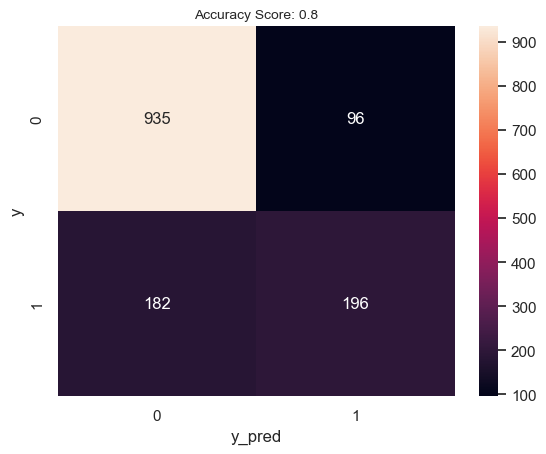

In [144]:
plot_confusion_matrix(y_test,y_pred_cb)

#### Cross-Validate (Çapraz Doğrulama)

In [145]:
cv_results = cross_validate(cb_model,
                            X,y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
cv_result_printer(cv_results)

Accuracy:   0.7985
Precision:  0.6545
Recall:     0.5120
F1:       0.5744
ROC AUC:    0.8403


#### GridSearchCV (Hiperparametre Optimizasyonu)

In [146]:
grid_params = {"iterations": [200, 500,700],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6,9]}

grid_search = GridSearchCV(
    
    cb_model,grid_params,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=3
).fit(X,y)
print("Best Params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Params: {'depth': 3, 'iterations': 700, 'learning_rate': 0.01}
Best ROC-AUC: 0.8491482989542096


#### Final Model

In [147]:
cb_final = grid_search.best_estimator_
finall_pred_cb = cb_final.predict(X_test)
check_errors(cb_final,X_test,y_test,finall_pred_cb)

 Model <catboost.core.CatBoostClassifier object at 0x000001CBA9A7F910>
        Accuracy : 0.8148
        Precision: 0.7097
        Recall   : 0.5238
        F1       : 0.6027
        ROC AUC  : 0.8686
        Log Loss : 0.3936
        


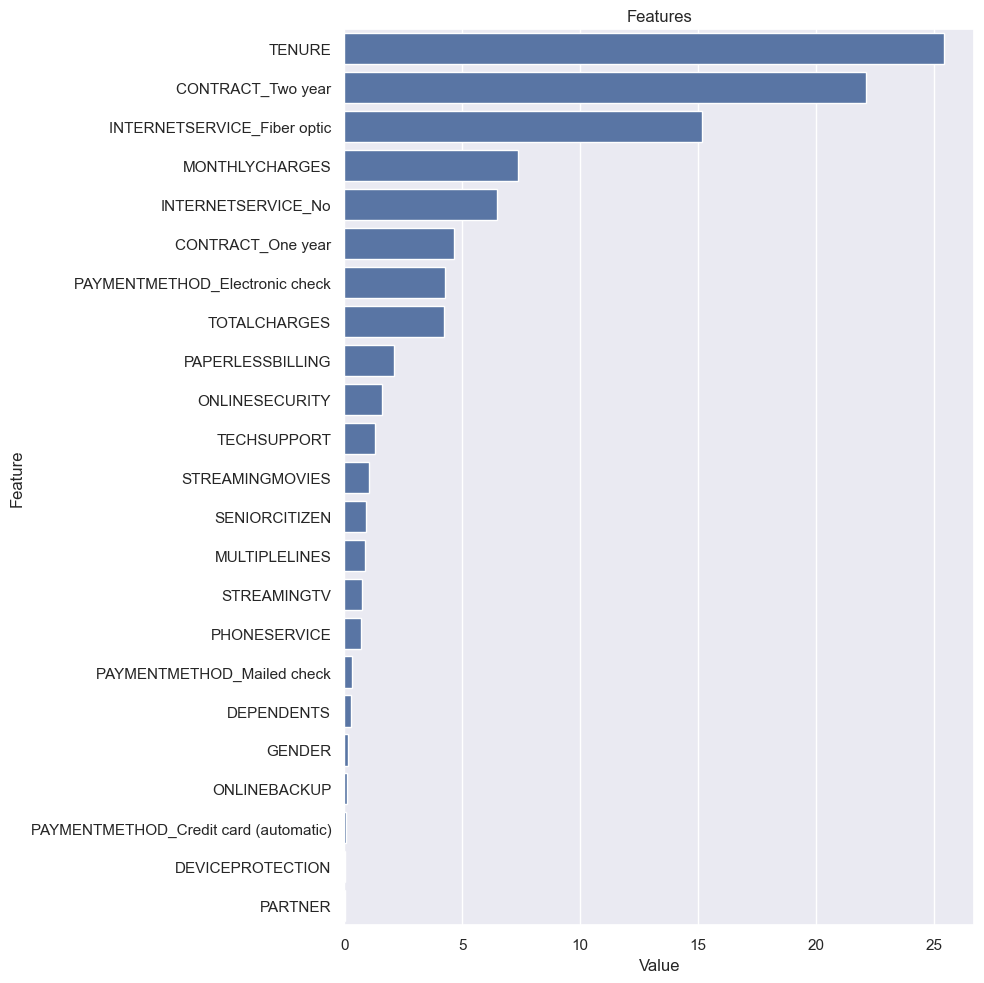

In [148]:
plot_importance(cb_final,X,X.shape[1])

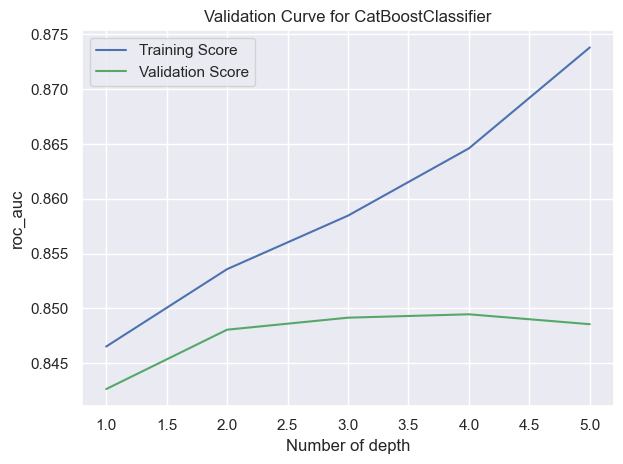

In [149]:
val_curve_params(cb_final,X,y,"depth",range(1,6),cv=5)

### ML ALGORİTMALARI VE SONUÇLARI

* Tüm final modellerini ve hata/başarı metrikleriyle beraber bir tablo haline getirdik.
* Bu bağlamda iş problemine özgü olarak bir model seçilip onun üzerinden analizler yaparak tekrar EDA basamaklarına dönülebilir.
* Log Loss değerinde minimum, diğerlerinde maximum olacak şekilde bir puanlama yapıp genel olarak bir başarı sıralaması yapılabilir.

In [232]:
final_table = ml_final_table([lr_final,knn_final,dtc_final,rfc_final,gbm_final,xgb_final,lgbm_final,cb_final])

In [233]:
final_table

,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss
LogisticRegression,0.801278,0.656051,0.544974,0.595376,0.855263,0.407778
KNeighborsClassifier,0.807665,0.658754,0.587302,0.620979,0.863583,0.402686
DecisionTreeClassifier,0.801987,0.638655,0.603175,0.620408,0.853187,0.406998
RandomForestClassifier,0.824698,0.749049,0.521164,0.614665,0.892847,0.374903
GradientBoostingClassifier,0.820440,0.722420,0.537037,0.616085,0.874331,0.387931
XGBClassifier,0.813343,0.697595,0.537037,0.606876,0.875402,0.384519
LGBMClassifier,0.826118,0.754789,0.521164,0.616588,0.887134,0.384444
CatBoostClassifier,0.814762,0.709677,0.523810,0.602740,0.868551,0.393570


In [234]:
points = {}
p = 0

for col in final_table:
    if col != "Log Loss":
        best_model = final_table.iloc[final_table[col].argmax()].name
        points[best_model] = points.get(best_model, 0) + 1
    else:
        best_model = final_table.iloc[final_table[col].argmin()].name
        points[best_model] = points.get(best_model, 0) + 1

points


{'LGBMClassifier': 2,
 'DecisionTreeClassifier': 1,
 'KNeighborsClassifier': 1,
 'RandomForestClassifier': 2}

## DEEP LEARNİNG (DL)

### Veri Seti Hazırlama ve Base Model

In [171]:
y = df["CHURN"].values
X = df.drop("CHURN",axis=1).to_numpy(dtype=np.float32)

In [172]:
X_train, X_val, y_train,y_val = train_test_split(X,y,random_state=11,test_size=0.2)

In [173]:
train_ds, val_ds = prepare_datasets(X_train,X_val,y_train,y_val,batch_size=32)

In [182]:
base_model = Sequential([
    Input(shape=(train_ds.element_spec[0].shape[1],)),
    Dense(50,activation="relu",kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32,activation="relu",kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1,activation="sigmoid")
])
optimizer = Adam(learning_rate=0.0001)
loss = "binary_crossentropy"
metrics = ["accuracy",
           AUC(name="auc"),
           Precision(name="precision"),
           Recall(name="recall")]

base_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics = metrics
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=50,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    "base_model.keras",
    monitor="val_loss",
    verbose=1,
    save_best_only=True
)

In [183]:
base_history = base_model.fit(
    train_ds,
    epochs=1000,
    validation_data=val_ds,
    callbacks=[early_stopping,model_checkpoint]
)

Epoch 1/1000


174/177 [============================>.] - ETA: 0s - loss: 0.9443 - accuracy: 0.4980 - auc: 0.5027 - precision: 0.2652 - recall: 0.5085
Epoch 1: val_loss improved from inf to 0.67820, saving model to base_model.keras
177/177 [==============================] - 2s 6ms/step - loss: 0.9416 - accuracy: 0.4998 - auc: 0.5052 - precision: 0.2673 - recall: 0.5111 - val_loss: 0.6782 - val_accuracy: 0.6693 - val_auc: 0.6831 - val_precision: 0.4035 - val_recall: 0.4868
Epoch 2/1000
170/177 [===========================>..] - ETA: 0s - loss: 0.7888 - accuracy: 0.5917 - auc: 0.6333 - precision: 0.3472 - recall: 0.6160
Epoch 2: val_loss improved from 0.67820 to 0.63296, saving model to base_model.keras
177/177 [==============================] - 1s 5ms/step - loss: 0.7856 - accuracy: 0.5946 - auc: 0.6369 - precision: 0.3501 - recall: 0.6211 - val_loss: 0.6330 - val_accuracy: 0.7346 - val_auc: 0.7875 - val_precision: 0.5037 - val_recall: 0.7196
Epoch 3/1000
177/177 [==============================] - ETA

#### Modelin grafikleri

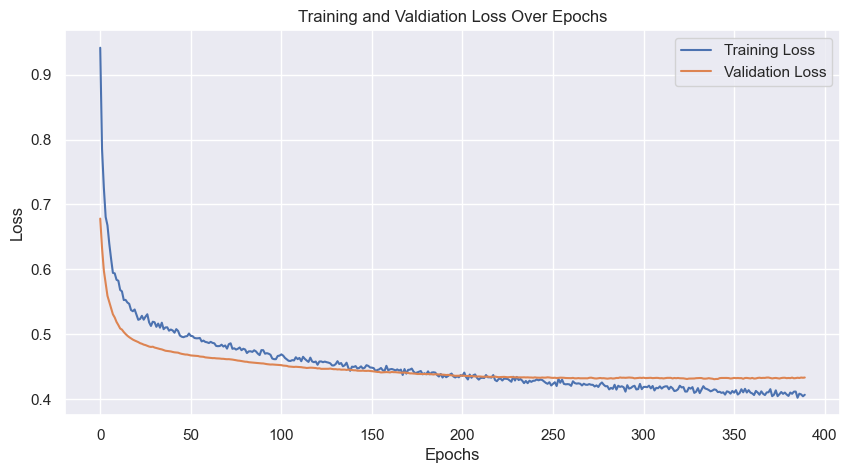

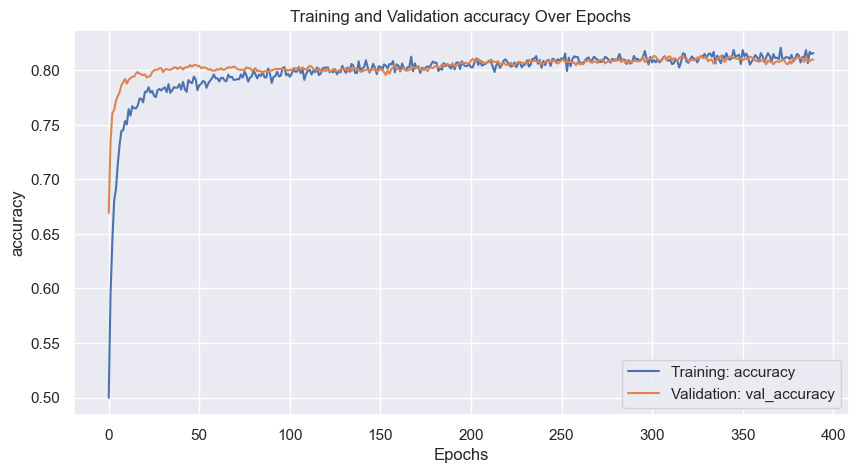

In [184]:
plot_training_history(base_history)

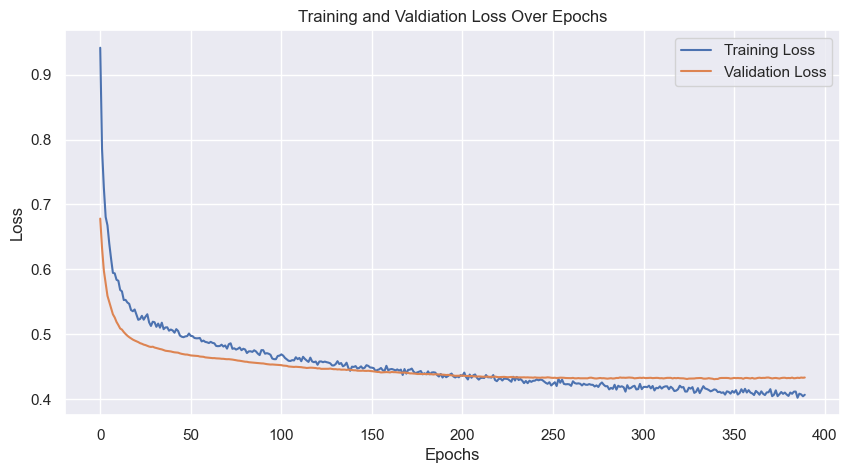

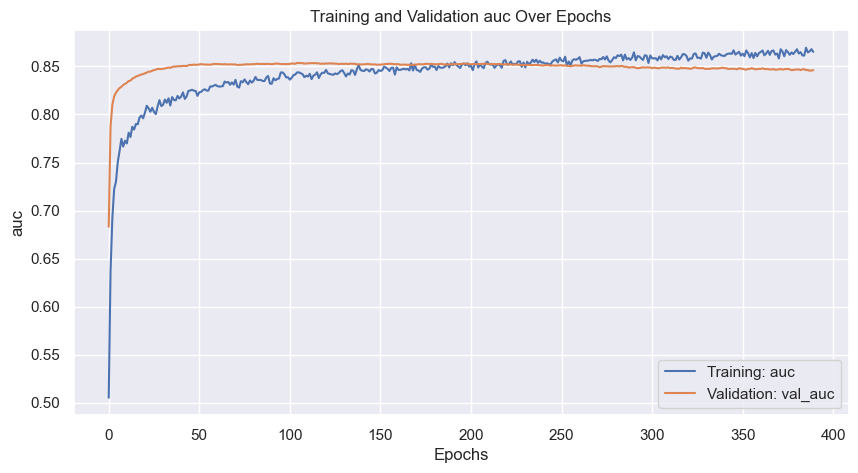

In [185]:
plot_training_history(base_history,train_metric="auc",val_metric="val_auc")

#### Base Modelin Başarı-Hata Metrikleri

In [195]:
base_bed = get_best_epoch_details(base_history)

Best epoch details: {'loss': 0.41492122411727905, 'accuracy': 0.8134540319442749, 'auc': 0.8611041903495789, 'precision': 0.6858108043670654, 'recall': 0.5446009635925293, 'val_loss': 0.43057310581207275, 'val_accuracy': 0.8105039000511169, 'val_auc': 0.8486905694007874, 'val_precision': 0.6796116232872009, 'val_recall': 0.5555555820465088, 'best_epoch': 340}


**Base Model Metrikleri**

| Metric        | Value                 |
|---------------|-----------------------|
| loss          | 0.414921              |
| accuracy      | 0.813454              |
| auc           | 0.861104              |
| precision     | 0.685810              |
| recall        | 0.544600              |
| val_loss      | 0.430573              |
| val_accuracy  | 0.810503              |
| val_auc       | 0.848690              |
| val_precision | 0.679611              |
| val_recall    | 0.555555              |


45/45 [==============================] - 0s 844us/step


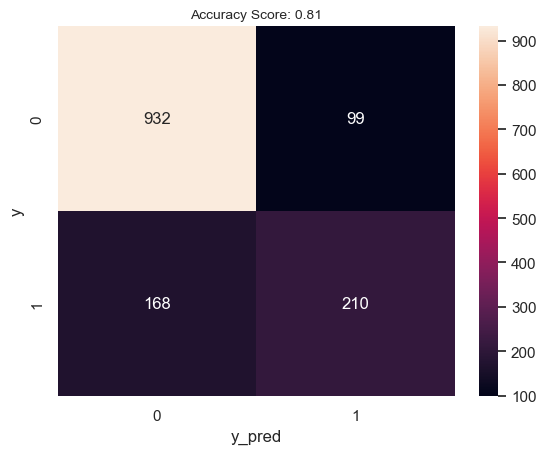

In [196]:
y_pred_base = (base_model.predict(X_val) > 0.5).astype("int32").flatten()
plot_confusion_matrix(y_val,y_pred_base)

*Final Tablosuna Ekleme*

In [235]:
final_table = add_results_from_history(base_history,
                         base_model,
                         X_val=X_val,
                         y_val=y_val,
                         model_name="Deep Learning Base",
                         result_tables=final_table
                         )

In [236]:
final_table

,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss
LogisticRegression,0.801278,0.656051,0.544974,0.595376,0.855263,0.407778
KNeighborsClassifier,0.807665,0.658754,0.587302,0.620979,0.863583,0.402686
DecisionTreeClassifier,0.801987,0.638655,0.603175,0.620408,0.853187,0.406998
RandomForestClassifier,0.824698,0.749049,0.521164,0.614665,0.892847,0.374903
GradientBoostingClassifier,0.820440,0.722420,0.537037,0.616085,0.874331,0.387931
XGBClassifier,0.813343,0.697595,0.537037,0.606876,0.875402,0.384519
LGBMClassifier,0.826118,0.754789,0.521164,0.616588,0.887134,0.384444
CatBoostClassifier,0.814762,0.709677,0.523810,0.602740,0.868551,0.393570
Deep Learning Base,0.810504,0.679612,0.555556,0.611354,0.848691,0.430573


### Hiperparametre Optimizasyonu ve Final Model

In [197]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(train_ds.element_spec[0].shape[1],)))

    for i in range(hp.Int("num_layers",1,5)):
        model.add(Dense(units=hp.Int("units_"+str(i), min_value=32,max_value=512,step=32),
                        activation=hp.Choice("activation_"+str(i),values=["relu","tanh","sigmoid","leaky_relu"]),
                        kernel_regularizer=l2(hp.Float("l2_"+str(i),min_value=0.0001,max_value=0.01,sampling="log"))))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float("dropout_"+str(i),min_value=0.0,max_value=0.6,step=0.1)))
    model.add(Dense(1,activation="sigmoid"))

    initial_learning_rate = hp.Float("initial_learning_rate",min_value=1e-4,max_value=1e-2,sampling="log")
    lr_schedule = ExponentialDecay(
        initial_learning_rate = initial_learning_rate,
        decay_steps = 100,
        decay_rate = 0.96,
        staircase=True
    )

    optimizer_choice = hp.Choice("optimizer",values=["sgd","adam","rmsprop"])
    if optimizer_choice == "sgd":
        optimizer = SGD(
            learning_rate=lr_schedule,
            momentum=hp.Float("momentum",min_value=0.0,max_value=0.9,step=0.1)
        )
    elif optimizer_choice == "adam":
        optimizer = Adam(
            learning_rate=lr_schedule,
            beta_1=hp.Float("beta1",min_value=0.85,max_value=0.99,step=0.01),
            beta_2=hp.Float("beta2",min_value=0.999,max_value=0.9999,step=0.0001),
            epsilon=hp.Float("epsilon",min_value=1e-8,max_value=1e-7, step=1e-8)
        )
    elif optimizer_choice == "rmsprop":
        optimizer = RMSprop(
            learning_rate=lr_schedule,
            rho=hp.Float("rho",min_value=0.8,max_value=0.99,step=0.01),
            epsilon=hp.Float("epsilon",min_value=0.0,max_value=0.9,step=0.1),
            momentum=hp.Float("momentum",min_value=0.0, max_value=0.9,step=0.1)
        )

    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy", AUC(name="auc"), Precision(name="precision"), Recall(name="recall")])
    return model


#### RandomSearch ve Arama Uzayı

In [199]:
random_search_tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial = 1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=30,
    verbose=1,
    restore_best_weights=True
)

In [200]:
random_search_tuner.search(
    train_ds,
    epochs = 100,
    validation_data = val_ds,
    callbacks = [early_stopping]
)

Trial 20 Complete [00h 02m 24s]
val_loss: 3.447652816772461

Best val_loss So Far: 0.4144367277622223
Total elapsed time: 00h 40m 27s


In [201]:
best_random_hp = random_search_tuner.get_best_hyperparameters(1)[0]
best_hp_dict = {k: best_random_hp.get(k) for k in best_random_hp.values.keys()}
print(best_hp_dict)

{'num_layers': 1, 'units_0': 192, 'activation_0': 'tanh', 'l2_0': 0.0004669925536911264, 'dropout_0': 0.5, 'initial_learning_rate': 0.0015950676949312772, 'optimizer': 'rmsprop', 'momentum': 0.6000000000000001, 'units_1': 288, 'activation_1': 'sigmoid', 'l2_1': 0.001876207787559134, 'dropout_1': 0.0, 'units_2': 64, 'activation_2': 'relu', 'l2_2': 0.00014976743663164954, 'dropout_2': 0.5, 'units_3': 32, 'activation_3': 'sigmoid', 'l2_3': 0.002665950753936075, 'dropout_3': 0.1, 'rho': 0.8, 'epsilon': 0.0}


#### En iyi parametreleri kaydetme.

In [202]:
dump(best_random_hp,"best_random_hp.joblib")

['best_random_hp.joblib']

In [203]:
best_random_model = random_search_tuner.get_best_models(num_models=1)[0]

45/45 [==============================] - 0s 798us/step


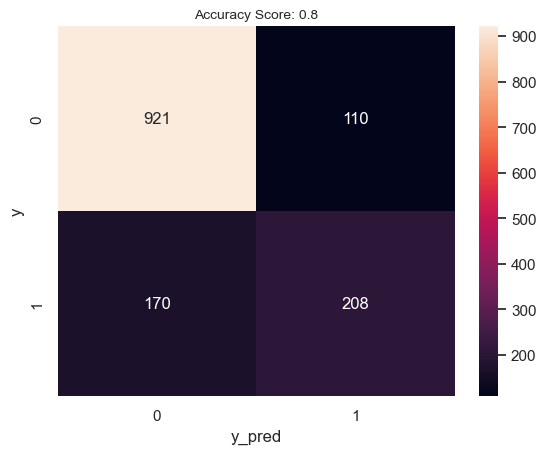

In [204]:
y_pred_random_best = (best_random_model.predict(X_val) > 0.5).astype("int32").flatten()
plot_confusion_matrix(y_val,y_pred_random_best)

#### Tuned Modeli kaydetme

In [205]:
best_random_model.save("best_random_model.keras")

#### Tuned Modeli Tekrar Eğitme (Final Model oluşturma) ve Başarı-Hata Metrikleri

In [207]:
dl_final = random_search_tuner.hypermodel.build(best_random_hp)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint("dl_final.keras",
                                   monitor="val_loss",
                                   save_best_only=True,
                                   verbose=1)

final_history = dl_final.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[early_stopping,model_checkpoint],
    verbose=1
)

Epoch 1/300
173/177 [============================>.] - ETA: 0s - loss: 0.5609 - accuracy: 0.7446 - auc: 0.7689 - precision: 0.5174 - recall: 0.4983
Epoch 1: val_loss improved from inf to 0.49626, saving model to dl_final.keras
177/177 [==============================] - 1s 5ms/step - loss: 0.5593 - accuracy: 0.7446 - auc: 0.7698 - precision: 0.5181 - recall: 0.4983 - val_loss: 0.4963 - val_accuracy: 0.7402 - val_auc: 0.8363 - val_precision: 0.8750 - val_recall: 0.0370
Epoch 2/300
176/177 [============================>.] - ETA: 0s - loss: 0.4773 - accuracy: 0.7763 - auc: 0.8124 - precision: 0.5903 - recall: 0.5047
Epoch 2: val_loss improved from 0.49626 to 0.44459, saving model to dl_final.keras
177/177 [==============================] - 1s 4ms/step - loss: 0.4773 - accuracy: 0.7762 - auc: 0.8125 - precision: 0.5903 - recall: 0.5044 - val_loss: 0.4446 - val_accuracy: 0.7935 - val_auc: 0.8481 - val_precision: 0.7005 - val_recall: 0.4021
Epoch 3/300
175/177 [============================>.]

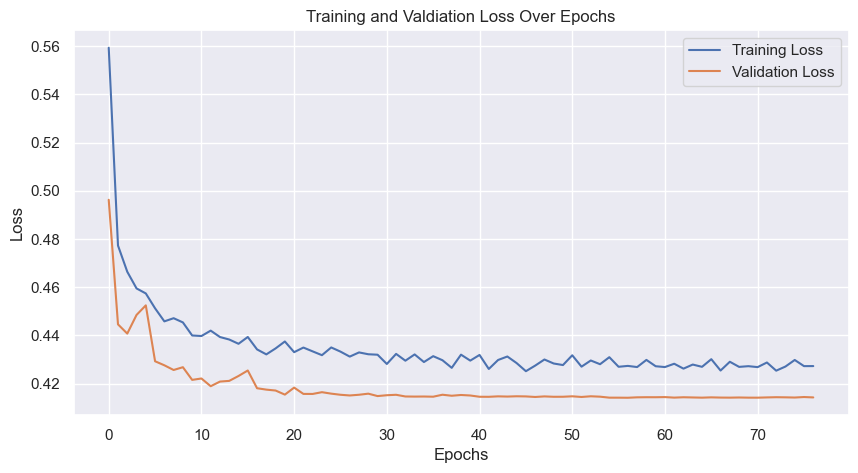

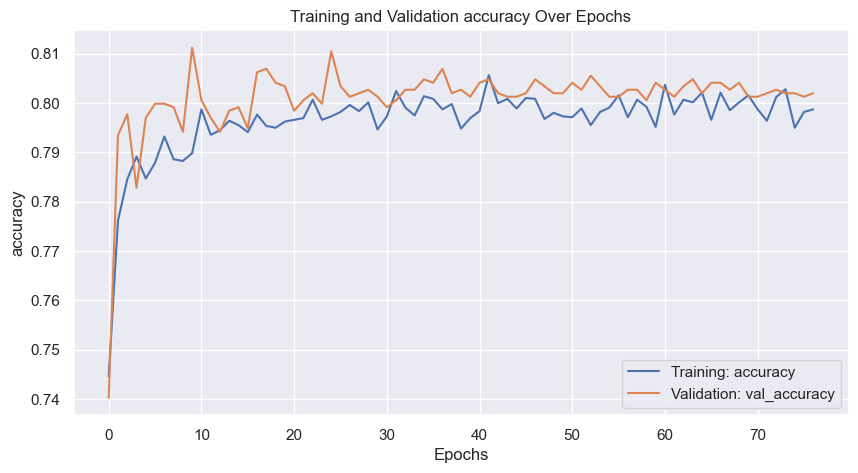

In [208]:
plot_training_history(final_history)

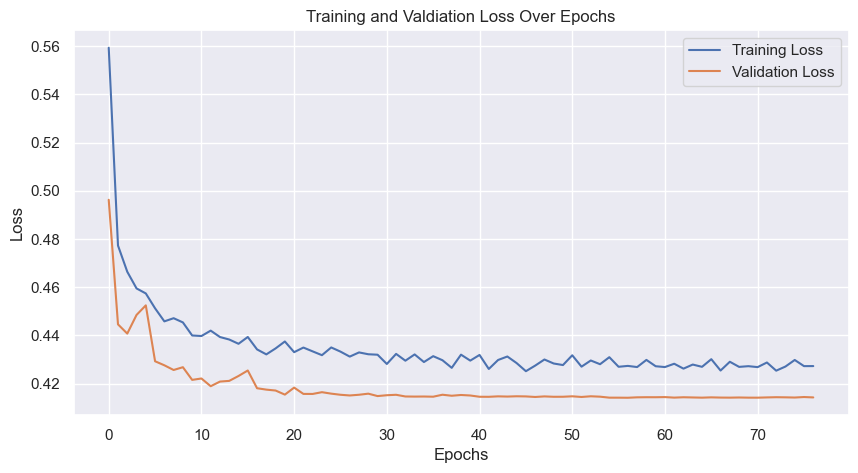

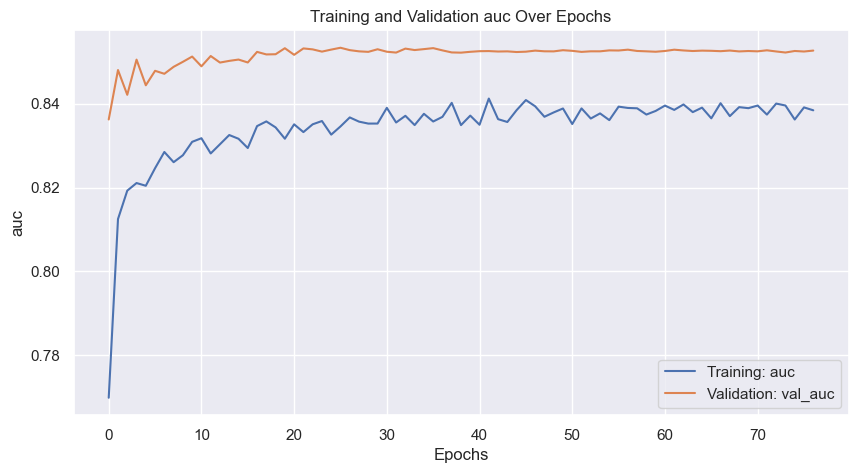

In [209]:
plot_training_history(final_history, train_metric="auc", val_metric="val_auc") 

In [210]:
final_bed = get_best_epoch_details(final_history)

Best epoch details: {'loss': 0.4273653030395508, 'accuracy': 0.7971246242523193, 'auc': 0.8390036225318909, 'precision': 0.6482112407684326, 'recall': 0.5103957056999207, 'val_loss': 0.41415467858314514, 'val_accuracy': 0.802696943283081, 'val_auc': 0.8529167175292969, 'val_precision': 0.6602563858032227, 'val_recall': 0.5449735522270203, 'best_epoch': 57}


**Final Model Metrikleri**

| Metric        | Value                 |
|---------------|-----------------------|
| loss          | 0.427365              |
| accuracy      | 0.797124              |
| auc           | 0.839003              |
| precision     | 0.648211              |
| recall        | 0.510395              |
| val_loss      | 0.414154              |
| val_accuracy  | 0.802696              |
| val_auc       | 0.852916              |
| val_precision | 0.660256              |
| val_recall    | 0.544973              |


**Base Model Metrikleri**

| Metric        | Value                 |
|---------------|-----------------------|
| loss          | 0.414921              |
| accuracy      | 0.813454              |
| auc           | 0.861104              |
| precision     | 0.685810              |
| recall        | 0.544600              |
| val_loss      | 0.430573              |
| val_accuracy  | 0.810503              |
| val_auc       | 0.848690              |
| val_precision | 0.679611              |
| val_recall    | 0.555555              |


#### Final Modeli Tabloya Ekleme

In [ ]:
def add_results_from_history(history, model, X_val, y_val, model_name, result_tables=None, threshold=0.5):
    h = history.history
    if "val_loss" not in h:
        raise ValueError("history.history 'val_loss' içermiyor.")

    best_idx = int(np.argmin(h["val_loss"])) 
    best_epoch = best_idx + 1

    val_acc  = float(h.get("val_accuracy", [np.nan])[best_idx])
    val_prec = float(h.get("val_precision", [np.nan])[best_idx])
    val_rec  = float(h.get("val_recall", [np.nan])[best_idx])
    val_auc_hist  = float(h.get("val_auc", [np.nan])[best_idx])
    val_loss_hist = float(h["val_loss"][best_idx])

    proba = model.predict(X_val, verbose=0).ravel()
    pred  = (proba >= threshold).astype(int)

    f1 = float(f1_score(y_val, pred, zero_division=0))

    row = pd.Series({
        "Accuracy":  val_acc,
        "Precision": val_prec,
        "Recall":    val_rec,
        "F1":        f1,
        "ROC AUC":   val_auc_hist,
        "Log Loss":  val_loss_hist
    }, name=model_name)


    if result_tables is None or not isinstance(result_tables, pd.DataFrame):
        result_tables = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","ROC AUC","Log Loss"])

    result_tables = pd.concat([result_tables, row.to_frame().T], axis=0)
    return result_tables

In [237]:
final_table = add_results_from_history(final_history,
                         dl_final,
                         X_val=X_val,
                         y_val=y_val,
                         model_name="Deep Learning Final",
                         result_tables=final_table
                         )

## Tüm Modelleri Karşılaştırma

In [239]:
final_table

,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss
LogisticRegression,0.801278,0.656051,0.544974,0.595376,0.855263,0.407778
KNeighborsClassifier,0.807665,0.658754,0.587302,0.620979,0.863583,0.402686
DecisionTreeClassifier,0.801987,0.638655,0.603175,0.620408,0.853187,0.406998
RandomForestClassifier,0.824698,0.749049,0.521164,0.614665,0.892847,0.374903
GradientBoostingClassifier,0.820440,0.722420,0.537037,0.616085,0.874331,0.387931
XGBClassifier,0.813343,0.697595,0.537037,0.606876,0.875402,0.384519
LGBMClassifier,0.826118,0.754789,0.521164,0.616588,0.887134,0.384444
CatBoostClassifier,0.814762,0.709677,0.523810,0.602740,0.868551,0.393570
Deep Learning Base,0.810504,0.679612,0.555556,0.611354,0.848691,0.430573
Deep Learning Final,0.802697,0.660256,0.544974,0.597101,0.852917,0.414155


In [ ]:
#####################################################################################################################################